# Covid-19 Data EDA and Forecast Modeling

#### Author: Joseph Denney
#### Email: joseph.d.denney@gmail.com
#### github: www.github.com/josephdenney/Tweet_Analysis

## Introduction

### Problem and Purpose

This project will use forecasting to model Covid-19 deaths  based on current hospital, infection, and death data. I will be using API html links to bring in up to date data regularly. My project will use supervised learning in the form of ARIMA and SARIMAX in order to predict future numbers.

Create easily viewable and customizable visualizations about Covid-19 deaths. If time allows, the project will involve building a dashboard to showcase the data. 

## Table of Contents

### Standard Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
%matplotlib inline
import functools
import plotly.express as px
import plotly.io as pio
from jupyter_plotly_dash import JupyterDash
import datetime as dt
from datetime import date
import pandas_datareader as pdr
# import dash
# import dash_core_components as dcc
# import dash_html_components as html
# from dash.dependencies import Input, Output,State
# app = JupyterDash('our app')
# pio.templates

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
scaler = MinMaxScaler()

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Custom Libraries

In [73]:
from Cust_Func import adf_test
from Cust_Func import create_ARIMA_summary_forecast_state as cas_state
from Cust_Func import create_ARIMA_summary_forecast_USA as cas_usa
from Cust_Func import create_NN_predict as create_nn
from Cust_Func import clean_dataframe as clean_df

## Explore Data

### Create New DataFrame

In [6]:
df_states = pd.read_csv('https://api.covidtracking.com/v1/states/daily.csv',index_col='date',parse_dates=True)
df_whole_US = pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv',index_col='date',parse_dates=True)

In [7]:
df_states.info

<bound method DataFrame.info of            state  positive  probableCases   negative  pending  \
date                                                            
2021-01-21    AK   50941.0            NaN  1380026.0      NaN   
2021-01-21    AL  432536.0        89554.0  1715242.0      NaN   
2021-01-21    AR  279220.0        54977.0  2091292.0      NaN   
2021-01-21    AS       0.0            NaN     2140.0      NaN   
2021-01-21    AZ  699942.0        40988.0  2628346.0      NaN   
...          ...       ...            ...        ...      ...   
2020-01-17    WA       0.0            NaN        NaN      NaN   
2020-01-16    WA       0.0            NaN        NaN      NaN   
2020-01-15    WA       0.0            NaN        NaN      NaN   
2020-01-14    WA       0.0            NaN        NaN      NaN   
2020-01-13    WA       NaN            NaN        NaN      NaN   

              totalTestResultsSource  totalTestResults  hospitalizedCurrently  \
date                                     

In [8]:
df_states.tail().index[0:100]

DatetimeIndex(['2020-01-17', '2020-01-16', '2020-01-15', '2020-01-14',
               '2020-01-13'],
              dtype='datetime64[ns]', name='date', freq=None)

In [9]:
df_states = df_states.dropna(subset=['death'])

In [10]:
df_states.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17382 entries, 2021-01-21 to 2020-02-10
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   state                        17382 non-null  object 
 1   positive                     17334 non-null  float64
 2   probableCases                7746 non-null   float64
 3   negative                     17206 non-null  float64
 4   pending                      1648 non-null   float64
 5   totalTestResultsSource       17382 non-null  object 
 6   totalTestResults             17361 non-null  float64
 7   hospitalizedCurrently        14949 non-null  float64
 8   hospitalizedCumulative       11161 non-null  float64
 9   inIcuCurrently               9641 non-null   float64
 10  inIcuCumulative              3252 non-null   float64
 11  onVentilatorCurrently        7679 non-null   float64
 12  onVentilatorCumulative       1113 non-null   float64
 13 

In [11]:
df_states['state'].unique() # list of states to iterate through

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

In [12]:
state_postal = ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY']

### Create DataFrame for Each State Deaths

In [13]:
# create a dataframe for each state, visualize data

In [14]:
df_begin = 'df_{state}'
df_list = []

In [15]:
df_states.sort_index()

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,
2020-02-10,NJ,NaN,NaN,NaN,NaN,posNeg,0.0,NaN,NaN,NaN,...,0,0,0,04c672d9235d9aeb73fb20462d13e41ab325b456,0,0,0,0,0,NaN
2020-02-11,NJ,NaN,NaN,NaN,NaN,posNeg,0.0,NaN,NaN,NaN,...,0,0,0,c517cc2a1c11e114c74f683aa30f00b560b61652,0,0,0,0,0,NaN
2020-02-12,NJ,NaN,NaN,NaN,NaN,posNeg,0.0,NaN,NaN,NaN,...,0,0,0,dc77f570d79d1398d81a9b86c99f901f37c5e0fe,0,0,0,0,0,NaN
2020-02-13,NJ,NaN,NaN,NaN,NaN,posNeg,0.0,NaN,NaN,NaN,...,0,0,0,b0269e519c685d2937b037df7dbe4a12b325a603,0,0,0,0,0,NaN
2020-02-14,NJ,NaN,NaN,NaN,NaN,posNeg,0.0,NaN,NaN,NaN,...,0,0,0,6d74e2c9d73e5222e1819cf58d39a59dd19bffee,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-21,NE,184482.0,NaN,708280.0,NaN,totalTestsViral,1966167.0,433.0,5632.0,NaN,...,892762,12,42,f4a3fd6603934de42261b6079906c0dac0c79bcb,0,0,0,0,0,NaN
2021-01-21,ND,96370.0,3974.0,292924.0,NaN,totalTestEncountersViral,1315777.0,54.0,3732.0,7.0,...,389294,13,9,e6f90cef88ced53dc040395500746b94eb5f40c0,0,0,0,0,0,NaN
2021-01-21,NC,698099.0,69537.0,7612132.0,NaN,posNeg,8310231.0,3666.0,NaN,780.0,...,8310231,139,0,028c66e8f48181e1ba32b861be5e7488a1ed2403,0,0,0,0,0,NaN


In [16]:
df_states[df_states['state']=='AK']

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,
2021-01-21,AK,50941.0,NaN,1380026.0,NaN,totalTestsViral,1430967.0,58.0,1177.0,NaN,...,1430967,1,7,86aafafe0b00c7f3e6560a03504d84b8c78c6160,0,0,0,0,0,NaN
2021-01-20,AK,50732.0,NaN,1369390.0,NaN,totalTestsViral,1420122.0,57.0,1170.0,NaN,...,1420122,23,8,62960acd8317b2a64484e93942c976b609e861f3,0,0,0,0,0,NaN
2021-01-19,AK,50572.0,NaN,1363959.0,NaN,totalTestsViral,1414531.0,61.0,1162.0,NaN,...,1414531,1,9,30862b954c0f6d2437a8abd3e93552247d3757e5,0,0,0,0,0,NaN
2021-01-18,AK,50447.0,NaN,1360313.0,NaN,totalTestsViral,1410760.0,58.0,1153.0,NaN,...,1410760,0,0,6a4860f714fc8735f6efe7fab574d8da64198375,0,0,0,0,0,NaN
2021-01-17,AK,50296.0,NaN,1354460.0,NaN,totalTestsViral,1404756.0,70.0,1153.0,NaN,...,1404756,0,1,b49b81df34179dc68c81dc7472d22f1afba58870,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-10,AK,NaN,NaN,23.0,9.0,totalTestsViral,23.0,NaN,1.0,NaN,...,23,0,0,3dc91f117f02b4ceb2740f1b7a0f50fe7f7a67e7,0,0,0,0,0,NaN
2020-03-09,AK,NaN,NaN,23.0,9.0,totalTestsViral,23.0,NaN,1.0,NaN,...,23,0,1,d079fbd221af733f452c4c09a96059c1b7403d68,0,0,0,0,0,NaN
2020-03-08,AK,NaN,NaN,14.0,6.0,totalTestsViral,14.0,NaN,NaN,NaN,...,14,0,0,ec0512b5cc8703196f5901589feb0640e43a851a,0,0,0,0,0,NaN


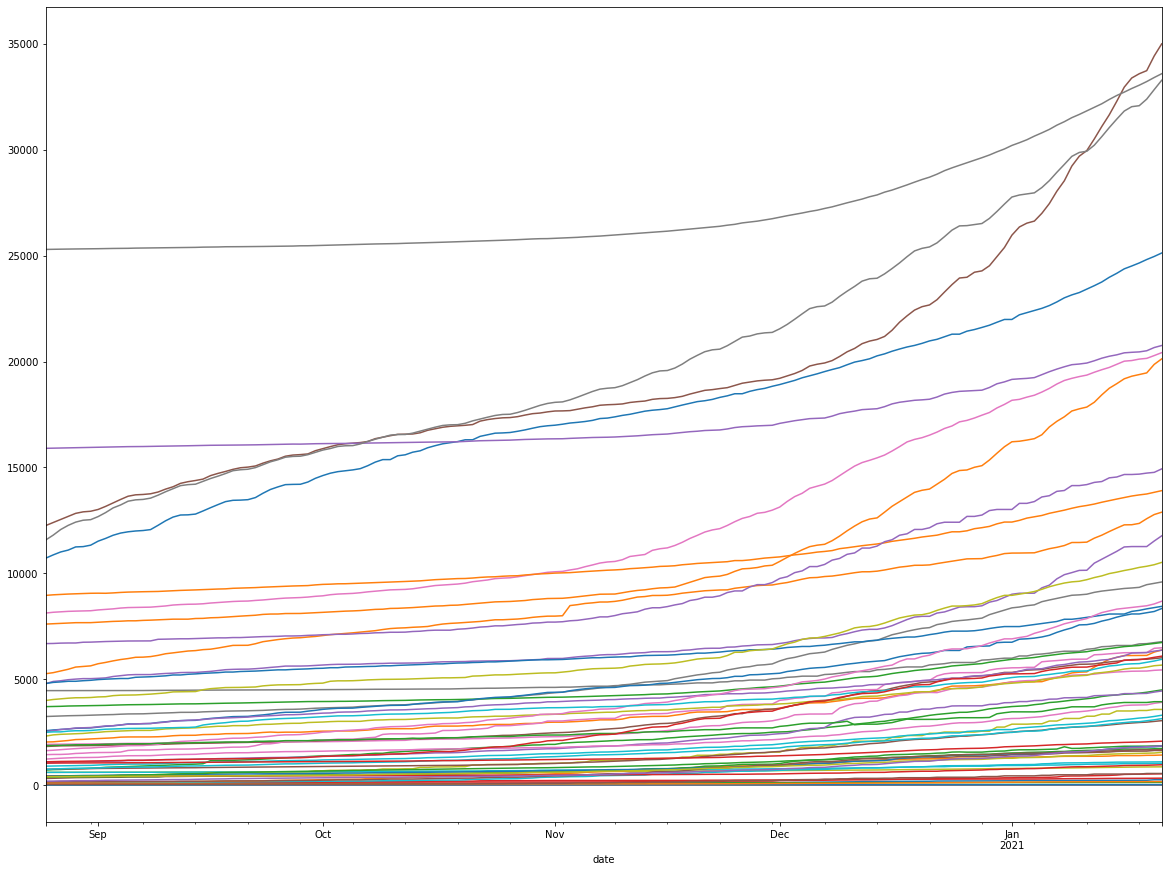

In [17]:
df_states_new = pd.date_range(df_states.index.min(),periods=len(df_states.index),freq='D')

for state in state_postal:
    df_individual = df_states[df_states['state']==state].death
    df_individual.iloc[:150].plot(figsize=(20,15));
    
# print(df_individual)

### Create multiple DataFrames
#### Index and Death Data Only

In [18]:
# df_list = [] # list of state dataframes

In [19]:
# for state in state_postal:
#     print(df_states[df_states['state']==state]) # awesome, now I'm printing each state df one at a time
#     df_list.append(df_states[df_states['state']==state])

In [20]:
# # def create_dataframe_list():
    
# #     for state in state_postal:
# #         df_list.append(df_begin.format(state=state))
            
# df_states[df_states['state']==state])
    
# def create_dataframes(): 
#     for state in state_postal:
#         state = pd.Dataframe(df_states[df_states['state']==state])
    
# # for df in df_list:
# #     print(df)
# #     df = df_states[df_states['state']==state]
# # #     df.plot(figsize=(20,5));

### Plot Alaska Death Count

In [21]:
df_AK = df_states[df_states['state']=='AK'] # let's just use Alaska for now

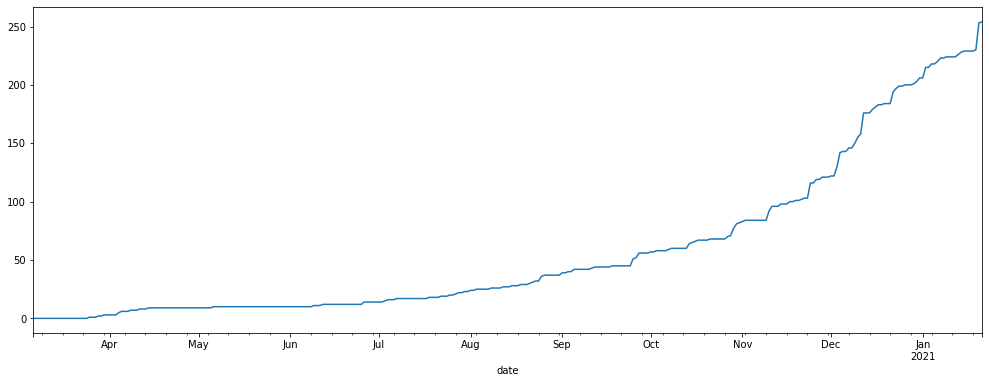

In [22]:
df_AK['death'].plot(figsize=(17,6));

### Hospital Bed and ICU Bed Data (Not daily updated data)

In [23]:
# import requests

# url = "https://api.covid19api.com/all"

# payload = {}
# headers= {}

# response = requests.request("GET", url, headers=headers, d= payload)

# print(response.text.encode('utf8'))

In [24]:
df_bed = pd.read_csv('Data/reference_hospitalization_all_locs.csv',index_col='date',parse_dates=True)

df_bed.tail()

,location_id,V1,location_name,allbed_mean,allbed_lower,allbed_upper,ICUbed_mean,ICUbed_lower,ICUbed_upper,InvVen_mean,...,est_infections_mean_p100k_rate,est_infections_lower_p100k_rate,est_infections_upper_p100k_rate,inf_cuml_mean,inf_cuml_upper,inf_cuml_lower,seroprev_mean,seroprev_upper,seroprev_lower,seroprev_data_type
date,,,,,,,,,,,,,,,,,,,,,
2021-03-28,60899,46949,Europe and Central Asia,265653.263253,164706.468520,341795.449905,35289.381461,23023.341323,45102.601640,17828.079768,...,NaN,NaN,NaN,1.717856e+08,1.927082e+08,1.504993e+08,NaN,NaN,NaN,NaN
2021-03-29,60899,46950,Europe and Central Asia,259712.192849,157779.681341,336098.388467,34479.702275,22091.482538,44282.273909,17414.672363,...,NaN,NaN,NaN,1.721117e+08,1.931445e+08,1.506805e+08,NaN,NaN,NaN,NaN
2021-03-30,60899,46951,Europe and Central Asia,253812.286545,151151.568820,330308.037537,33675.817103,21219.554344,43385.733833,17004.357986,...,NaN,NaN,NaN,1.724290e+08,1.935697e+08,1.508554e+08,NaN,NaN,NaN,NaN
2021-03-31,60899,46952,Europe and Central Asia,247951.449702,145534.000211,324495.161851,32877.877387,20421.770898,42609.319496,16597.235006,...,NaN,NaN,NaN,1.727376e+08,1.939841e+08,1.510242e+08,NaN,NaN,NaN,NaN
2021-04-01,60899,46953,Europe and Central Asia,242132.408547,139973.774694,317574.415868,32085.996051,19594.471039,41728.913432,16193.294588,...,NaN,NaN,NaN,1.730377e+08,1.943883e+08,1.511876e+08,NaN,NaN,NaN,NaN


In [25]:
df_bed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 165633 entries, 2020-02-04 to 2021-04-01
Data columns (total 72 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   location_id                       165633 non-null  int64  
 1   V1                                165633 non-null  int64  
 2   location_name                     165633 non-null  object 
 3   allbed_mean                       165633 non-null  float64
 4   allbed_lower                      165633 non-null  float64
 5   allbed_upper                      165633 non-null  float64
 6   ICUbed_mean                       165633 non-null  float64
 7   ICUbed_lower                      165633 non-null  float64
 8   ICUbed_upper                      165633 non-null  float64
 9   InvVen_mean                       165633 non-null  float64
 10  InvVen_lower                      165633 non-null  float64
 11  InvVen_upper                      16

In [26]:
df_bed = df_bed.dropna(subset=['deaths_mean'])

In [27]:
df_bed.columns

Index(['location_id', 'V1', 'location_name', 'allbed_mean', 'allbed_lower',
       'allbed_upper', 'ICUbed_mean', 'ICUbed_lower', 'ICUbed_upper',
       'InvVen_mean', 'InvVen_lower', 'InvVen_upper', 'admis_mean',
       'admis_lower', 'admis_upper', 'newICU_mean', 'newICU_lower',
       'newICU_upper', 'bedover_mean', 'bedover_lower', 'bedover_upper',
       'icuover_mean', 'icuover_lower', 'icuover_upper', 'hosp_data_type',
       'deaths_data_type', 'deaths_mean', 'deaths_lower', 'deaths_upper',
       'totdea_mean', 'totdea_lower', 'totdea_upper', 'deaths_mean_smoothed',
       'deaths_lower_smoothed', 'deaths_upper_smoothed',
       'totdea_mean_smoothed', 'totdea_lower_smoothed',
       'totdea_upper_smoothed', 'mobility_data_type', 'mobility_composite',
       'total_tests_data_type', 'total_tests',
       'confirmed_infections_data_type', 'confirmed_infections',
       'est_infections_data_type', 'est_infections_mean',
       'est_infections_lower', 'est_infections_upper', 'tot

In [28]:
df_bed['location_name'].unique()

array(['Global', 'China', 'Taiwan (Province of China)', 'Indonesia',
       'Malaysia', 'Maldives', 'Myanmar', 'Philippines', 'Sri Lanka',
       'Thailand', 'Viet Nam', 'Armenia', 'Azerbaijan', 'Georgia',
       'Kazakhstan', 'Kyrgyzstan', 'Tajikistan', 'Uzbekistan', 'Albania',
       'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czechia',
       'Hungary', 'North Macedonia', 'Montenegro', 'Poland', 'Romania',
       'Serbia', 'Slovakia', 'Slovenia', 'Belarus', 'Estonia', 'Latvia',
       'Lithuania', 'Republic of Moldova', 'Russian Federation',
       'Ukraine', 'Japan', 'Republic of Korea', 'Singapore', 'Australia',
       'New Zealand', 'Andorra', 'Austria', 'Belgium', 'Cyprus',
       'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Iceland',
       'Ireland', 'Israel', 'Italy', 'Luxembourg', 'Malta', 'Netherlands',
       'Norway', 'Portugal', 'Spain', 'Sweden', 'Switzerland',
       'United Kingdom', 'Argentina', 'Chile', 'Uruguay', 'Canada',
       'United States of Am

### Filter for USA and Global Data

In [29]:
df_USA = df_bed[df_bed['location_name']=='United States of America']
df_USA = df_USA.filter(regex='mean',axis=1) 

In [30]:
df_global = df_bed[df_bed['location_name']=='Global']
df_global = df_global.filter(regex='mean',axis=1) 

In [31]:
df_USA.columns

Index(['allbed_mean', 'ICUbed_mean', 'InvVen_mean', 'admis_mean',
       'newICU_mean', 'bedover_mean', 'icuover_mean', 'deaths_mean',
       'totdea_mean', 'deaths_mean_smoothed', 'totdea_mean_smoothed',
       'est_infections_mean', 'deaths_mean_p100k_rate',
       'totdea_mean_p100k_rate', 'deaths_mean_smoothed_p100k_rate',
       'totdea_mean_smoothed_p100k_rate', 'est_infections_mean_p100k_rate',
       'inf_cuml_mean', 'seroprev_mean'],
      dtype='object')

In [32]:
df_USA.head()
len(df_USA)

423

In [33]:
# let's look at multiple statistics 

In [34]:
stats = ['allbed_mean', 'ICUbed_mean', 'InvVen_mean', 'admis_mean',
       'newICU_mean', 'bedover_mean', 'icuover_mean', 'deaths_mean',
       'totdea_mean', 'deaths_mean_smoothed', 'totdea_mean_smoothed',
       'est_infections_mean', 'deaths_mean_p100k_rate', 
       'est_infections_mean_p100k_rate', 'seroprev_mean']

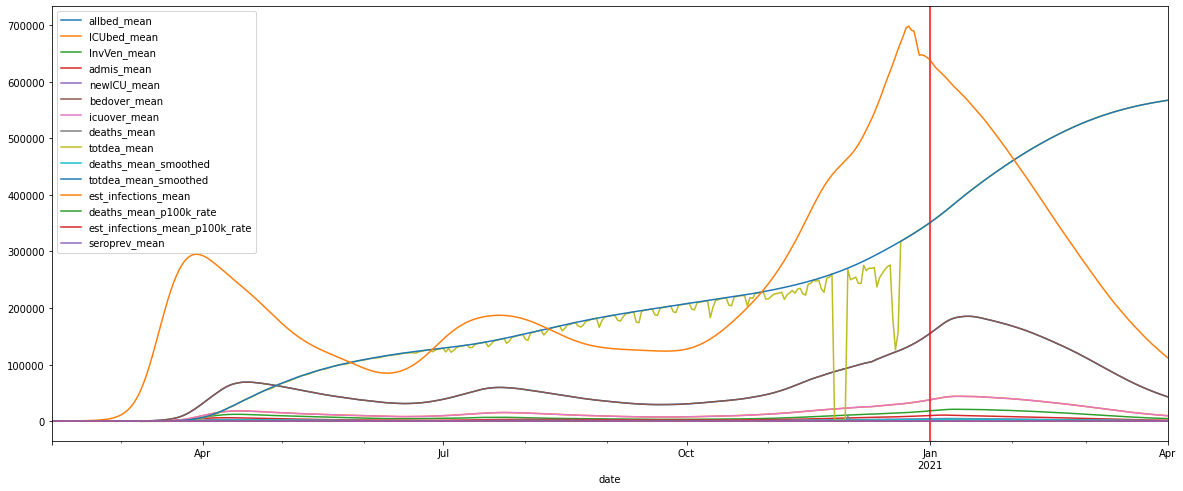

In [35]:
for i in stats:
    ax = df_USA[i].plot(legend=True,figsize=(20,8));
    ax.axvline(x='2021-01-01',color='r',alpha=.1);

allbed_mean
ICUbed_mean
InvVen_mean
admis_mean
newICU_mean
bedover_mean
icuover_mean
deaths_mean
totdea_mean
deaths_mean_smoothed
totdea_mean_smoothed
est_infections_mean
deaths_mean_p100k_rate
est_infections_mean_p100k_rate
seroprev_mean


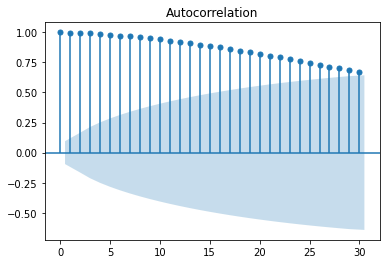

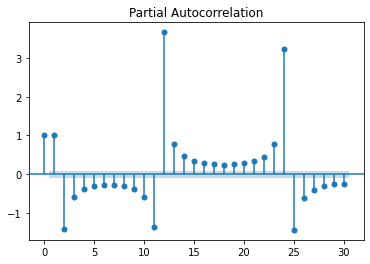

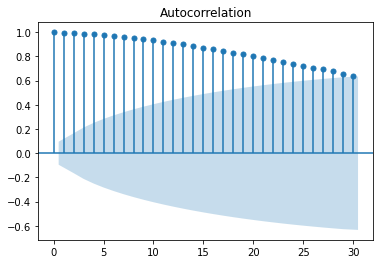

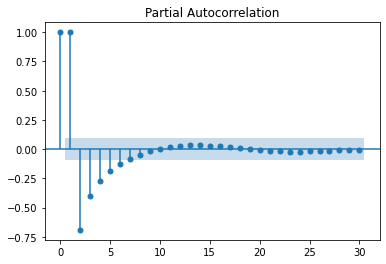

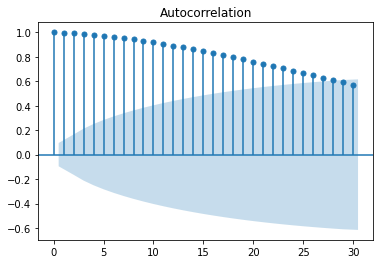

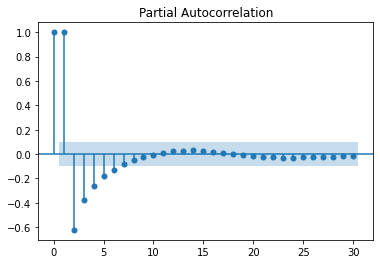

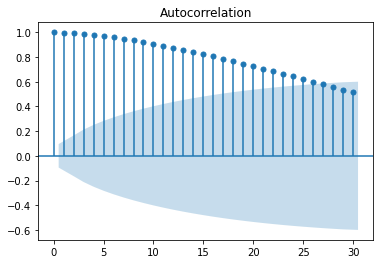

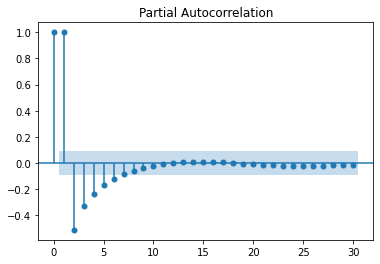

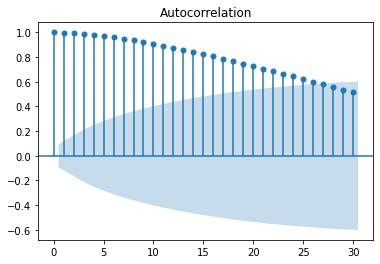

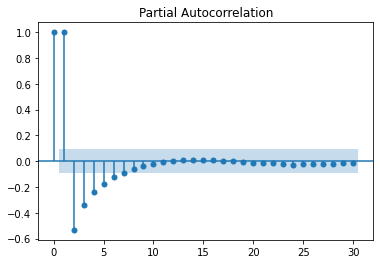

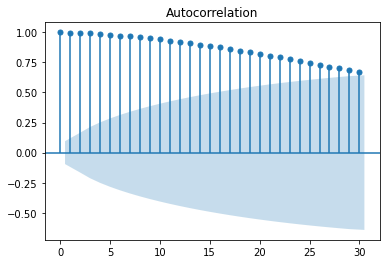

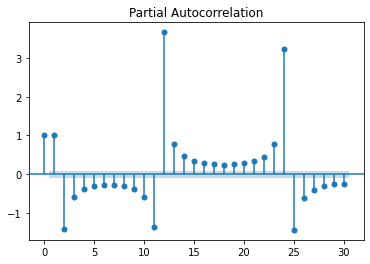

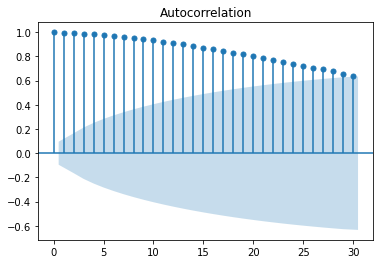

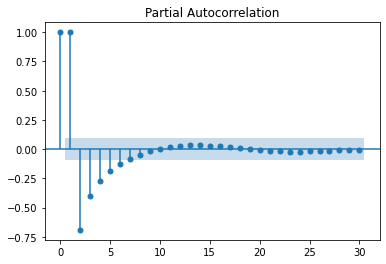

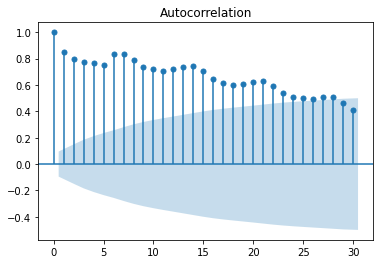

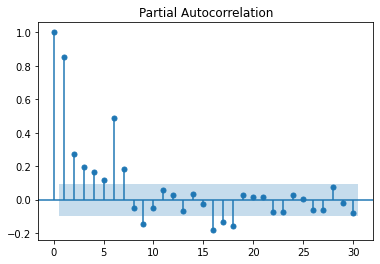

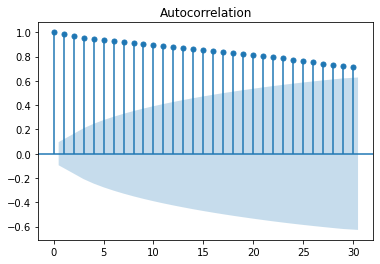

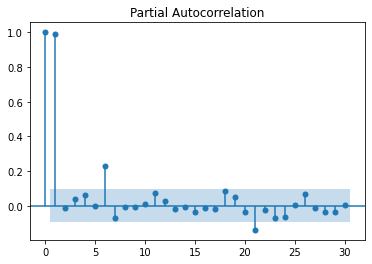

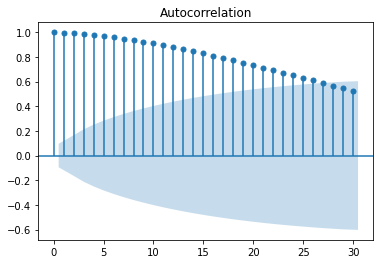

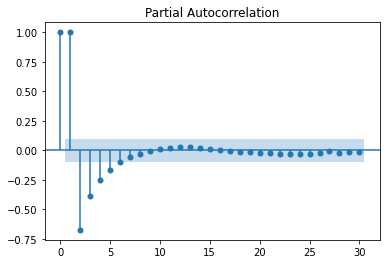

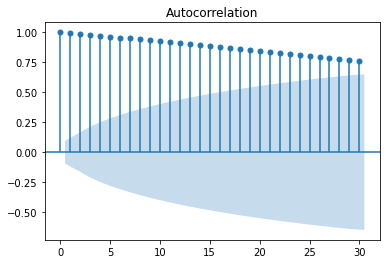

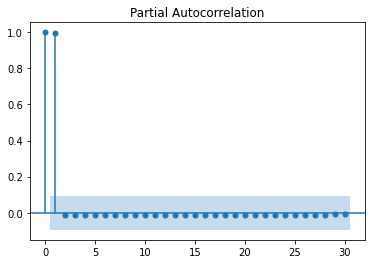

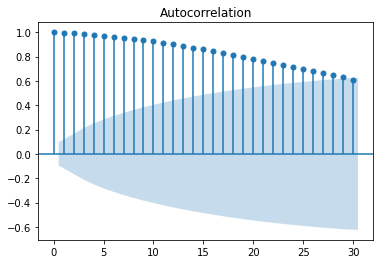

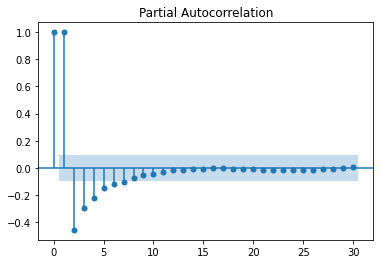

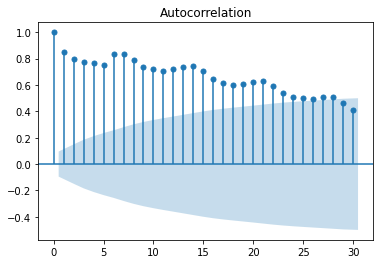

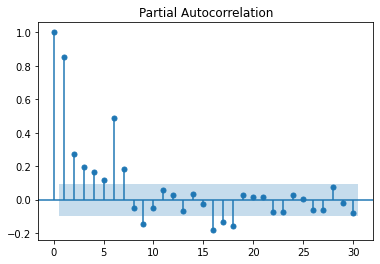

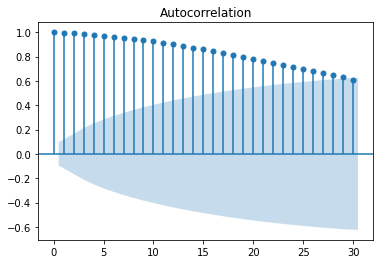

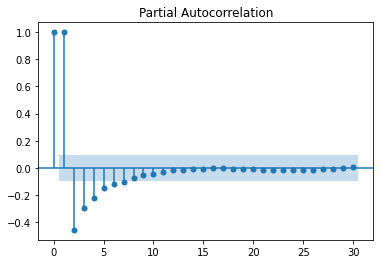

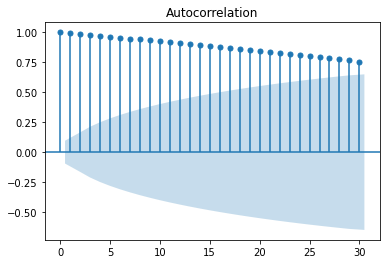

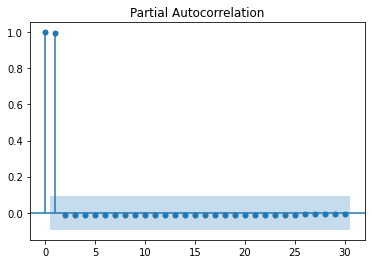

In [36]:
for i in stats:
    print(i)
    plot_acf(df_USA[i],lags=30);
    plot_pacf(df_USA[i],lags=30);

In [37]:
from IPython.display import IFrame
IFrame("Data/IHME_COVID_19_Data_Release_Information_Sheet.pdf", width=1000, height=600)

In [38]:
# important metrics 
'allbed_mean' # total beds with a covid patient 
'ICUbed_mean' # ICU beds with a covid patient
'InvVen_mean' # ventilators supporting a covid patient
'newICU_mean' # mean number of new people in ICU
'icuover_mean' # covid ICU beds needed less available ICU capacity
'deaths_mean' # mean daily deaths

'deaths_mean'

In [39]:
graph_list = ['allbed_mean', 'ICUbed_mean', 'InvVen_mean', 'newICU_mean', 'icuover_mean', 'deaths_mean']

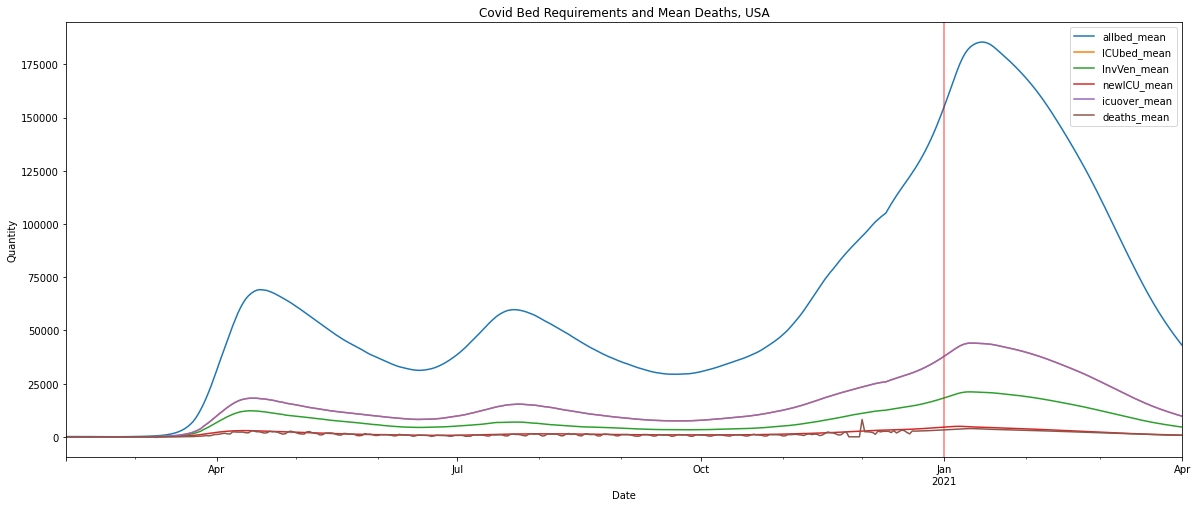

In [40]:
for i in graph_list:
    ax = df_USA[i].plot(legend=True,figsize=(20,8), title='Covid Bed Requirements and Mean Deaths, USA',
                   ylabel='Quantity',xlabel='Date')
    ax.axvline(x='2021-01-01',color='r',alpha=.1);

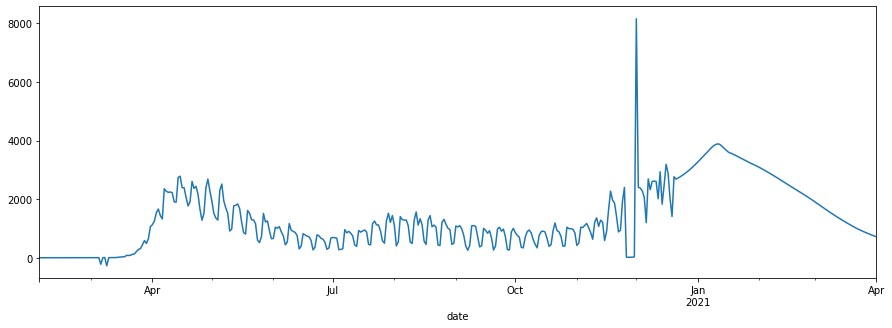

In [41]:
df_USA['deaths_mean'].plot(figsize=(15,5)); # take moving average and reinsert to DF

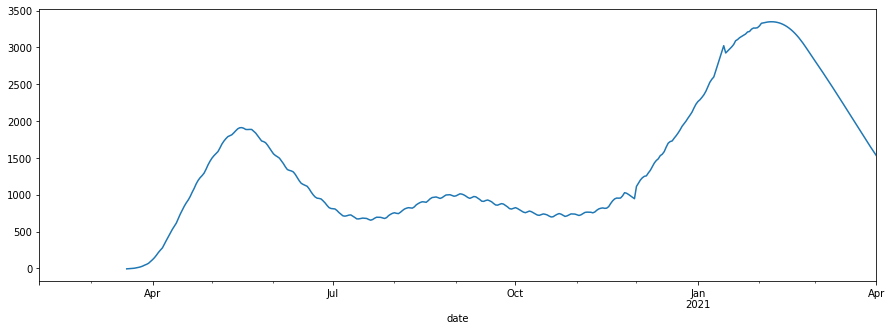

In [42]:
df_USA.rolling(window=45).mean()['deaths_mean'].plot(figsize=(15,5));

In [43]:
df_USA['rolling mean'] = df_USA.rolling(window=45).mean()['deaths_mean']

## Models

### Auto Regression Models

### Alaska SARIMA Model

In [44]:
df_AK = df_AK.sort_index()

In [45]:
df_AK = df_AK.dropna(subset=['death'])

In [46]:
df_alaska = pd.DataFrame(df_AK)

In [47]:
print(df_alaska.index.min())
print(df_alaska.index.max())
print('Length of dataframe: ' , len(df_alaska))

2020-03-06 00:00:00
2021-01-21 00:00:00
Length of dataframe:  322


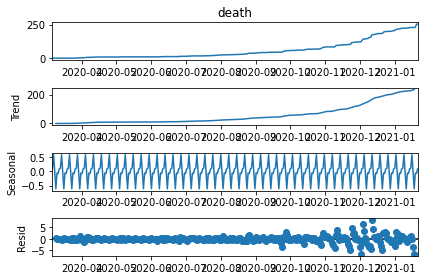

In [48]:
sd(df_alaska['death'], model='additive').plot(); # alaska = seasonal

In [49]:
stepwise_fit = auto_arima(df_alaska['death'],start_p=0,start_q=0,max_p=10,
                          max_q=10, seasonal=True, seasonal_test='ocsb', maxiter=75, method='lbfgs',
                          n_jobs=-1,stepwise=True)

In [50]:
stepwise_fit.order

(0, 2, 1)

In [51]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  322
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -701.048
Date:                Thu, 21 Jan 2021   AIC                           1408.095
Time:                        18:17:50   BIC                           1419.400
Sample:                             0   HQIC                          1412.610
                                - 322                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0081      0.006      1.351      0.177      -0.004       0.020
ma.L1         -0.9759      0.011    -88.504      0.000      -0.997      -0.954
sigma2         4.6374      0.157     29.566      0.000       4.330       4.945
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             25215.23
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              76.18   Skew:                             5.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
length = len(df_alaska)-45

In [53]:
train_data = df_alaska.iloc[:length]
test_data = df_alaska.iloc[length:]

In [54]:
train_data

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,
2020-03-06,AK,NaN,NaN,8.0,1.0,totalTestsViral,8.0,NaN,NaN,NaN,...,8,0,0,1cccb785fe70d960475d4b202a3d0fc678c81e41,0,0,0,0,0,NaN
2020-03-07,AK,NaN,NaN,12.0,2.0,totalTestsViral,12.0,NaN,NaN,NaN,...,12,0,0,a2776acac3d2b1dea060a3c20f4b508d5c00fd3d,0,0,0,0,0,NaN
2020-03-08,AK,NaN,NaN,14.0,6.0,totalTestsViral,14.0,NaN,NaN,NaN,...,14,0,0,ec0512b5cc8703196f5901589feb0640e43a851a,0,0,0,0,0,NaN
2020-03-09,AK,NaN,NaN,23.0,9.0,totalTestsViral,23.0,NaN,1.0,NaN,...,23,0,1,d079fbd221af733f452c4c09a96059c1b7403d68,0,0,0,0,0,NaN
2020-03-10,AK,NaN,NaN,23.0,9.0,totalTestsViral,23.0,NaN,1.0,NaN,...,23,0,0,3dc91f117f02b4ceb2740f1b7a0f50fe7f7a67e7,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-03,AK,33291.0,NaN,1007214.0,NaN,totalTestsViral,1040505.0,157.0,783.0,NaN,...,1040505,8,15,127e848f18fa8ba2c3a21f9c3b0c27c0799fb3c4,0,0,0,0,0,NaN
2020-12-04,AK,34041.0,NaN,1016328.0,NaN,totalTestsViral,1050369.0,151.0,794.0,NaN,...,1050369,12,11,ce3d200f868523c2b75b16565cf8fbf4ba1039b8,0,0,0,0,0,NaN
2020-12-05,AK,34963.0,NaN,1032268.0,NaN,totalTestsViral,1067231.0,166.0,799.0,NaN,...,1067231,1,5,013d9ddc897af4818737f4f7187e540363488dc1,0,0,0,0,0,NaN


In [55]:
test_data

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,
2020-12-08,AK,36758.0,NaN,1052220.0,NaN,totalTestsViral,1088978.0,159.0,827.0,NaN,...,1088978,0,22,d1b8f602b924805487bf555f1724b7d951e7cc4e,0,0,0,0,0,NaN
2020-12-09,AK,37342.0,NaN,1062213.0,NaN,totalTestsViral,1099555.0,165.0,847.0,NaN,...,1099555,4,20,89f8425bebab112809cf24f94afbb0f6c8e68a3f,0,0,0,0,0,NaN
2020-12-10,AK,37962.0,NaN,1075398.0,NaN,totalTestsViral,1113360.0,164.0,860.0,NaN,...,1113360,5,13,e74e702804d6b430c17a184b4acbae511972b54c,0,0,0,0,0,NaN
2020-12-11,AK,38584.0,NaN,1084961.0,NaN,totalTestsViral,1123545.0,146.0,869.0,NaN,...,1123545,3,9,ae781d8a2556aad596db12c9f95c3faaa7664ce9,0,0,0,0,0,NaN
2020-12-12,AK,39101.0,NaN,1094317.0,NaN,totalTestsViral,1133418.0,146.0,883.0,NaN,...,1133418,18,14,ef3f2f0abcb797822dd24f9eec0e6993f25943d9,0,0,0,0,0,NaN
2020-12-13,AK,39738.0,NaN,1103360.0,NaN,totalTestsViral,1143098.0,139.0,886.0,NaN,...,1143098,0,3,5bb1f21bb99f720474d81fa05d9f04b51ecb4904,0,0,0,0,0,NaN
2020-12-14,AK,40160.0,NaN,1107400.0,NaN,totalTestsViral,1147560.0,140.0,889.0,NaN,...,1147560,0,3,e5a29d80105d770991491df6181016aba47409ad,0,0,0,0,0,NaN
2020-12-15,AK,40438.0,NaN,1117429.0,NaN,totalTestsViral,1157867.0,140.0,908.0,NaN,...,1157867,3,19,62c0dca8a4bef2c2565d6a16a5ad6d70a573a2c0,0,0,0,0,0,NaN
2020-12-16,AK,41041.0,NaN,1125104.0,NaN,totalTestsViral,1166145.0,146.0,921.0,NaN,...,1166145,2,13,5b761687026839854946df03828dae6122365638,0,0,0,0,0,NaN


In [56]:
model = sm.tsa.statespace.SARIMAX(train_data['death'],trend='ct', order=(0,2,1))
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  death   No. Observations:                  277
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -509.415
Date:                Thu, 21 Jan 2021   AIC                           1026.830
Time:                        18:17:51   BIC                           1041.297
Sample:                    03-06-2020   HQIC                          1032.636
                         - 12-07-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0148      0.212     -0.070      0.944      -0.430       0.400
drift          0.0002      0.001      0.182      0.855      -0.002       0.002
ma.L1         -0.6245      0.031    -20.192      0.0

In [57]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1

In [58]:
predictions_AK = res.predict(start,end,typ='endogenous').rename('SARIMAX(0,2,1) Predictions')

In [59]:
train_data.index

DatetimeIndex(['2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15',
               ...
               '2020-11-28', '2020-11-29', '2020-11-30', '2020-12-01',
               '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05',
               '2020-12-06', '2020-12-07'],
              dtype='datetime64[ns]', name='date', length=277, freq=None)

In [60]:
test_data.index

DatetimeIndex(['2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11',
               '2020-12-12', '2020-12-13', '2020-12-14', '2020-12-15',
               '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-19',
               '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-27',
               '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31',
               '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21'],
              dtype='datetime64[ns]', name='date', freq=None)

In [61]:
predictions_AK = pd.DataFrame(predictions_AK)

In [62]:
predictions_AK.index.name = 'date'

#### Compare Test Data with Predictions

In [63]:
train_data.index.freq = 'D'
test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
# perform sort_index on dataframe to correct. set frequencies to match for plotting
# on same visualization

In [64]:
pd.DataFrame(test_data['death']).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2020-12-08 to 2021-01-21
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   death   45 non-null     float64
dtypes: float64(1)
memory usage: 720.0 bytes


In [65]:
predictions_AK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2020-12-08 to 2021-01-21
Freq: D
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SARIMAX(0,2,1) Predictions  45 non-null     float64
dtypes: float64(1)
memory usage: 720.0 bytes


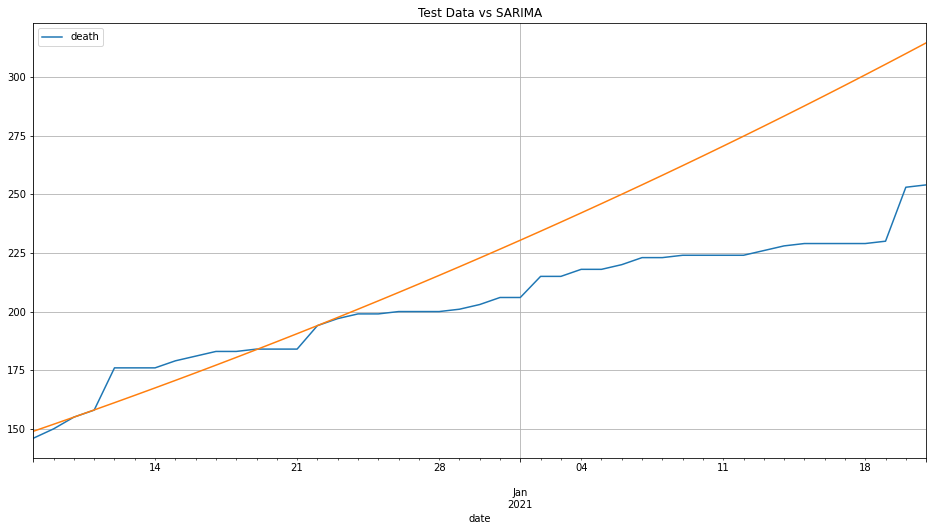

In [66]:
pd.DataFrame(test_data['death']).plot(figsize=(16,8),legend=True,title='Test Data vs SARIMA',grid=True)
plt.plot(pd.DataFrame(predictions_AK))
plt.show()

In [67]:
model = sm.tsa.statespace.SARIMAX(df_alaska['death'],trend='ct', order=(0,2,1))
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  death   No. Observations:                  322
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -719.630
Date:                Thu, 21 Jan 2021   AIC                           1447.259
Time:                        18:17:51   BIC                           1462.332
Sample:                    03-06-2020   HQIC                          1453.278
                         - 01-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0829      0.248     -0.335      0.738      -0.568       0.403
drift          0.0005      0.001      0.516      0.606      -0.001       0.002
ma.L1         -0.7551      0.035    -21.619      0.0

In [68]:
fcast = res.predict(start=len(df_AK),end=len(df_AK)+45, typ='endogenous').rename('SARIMAX FORECAST')

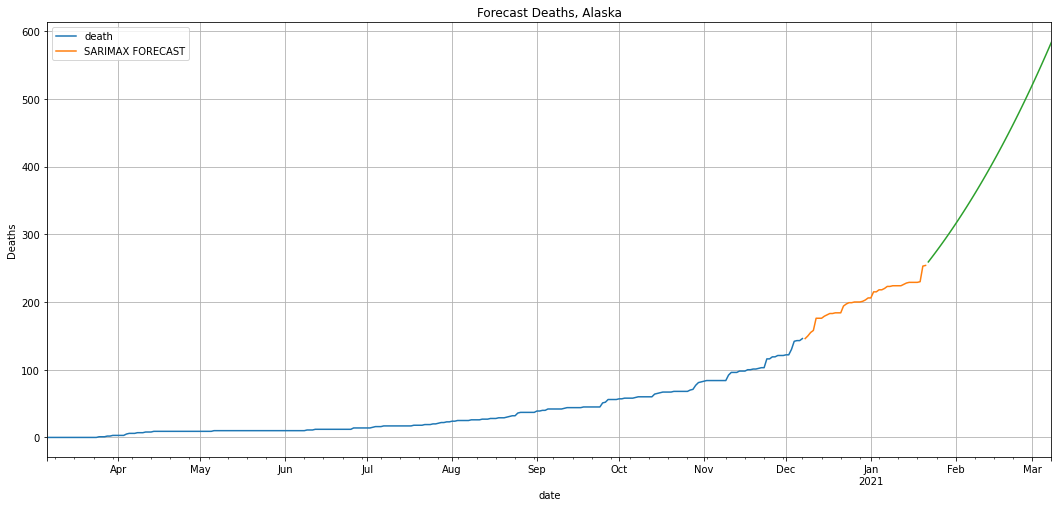

In [69]:
fig, ax = plt.subplots()

train_data['death'].plot(figsize=(16,8),legend=True,ylabel='Deaths',title='Forecast Deaths, Alaska',grid=True);
test_data['death'].plot(grid=True);
fcast.plot(legend=True,figsize=(18,8)); 
ax.grid();
plt.show();

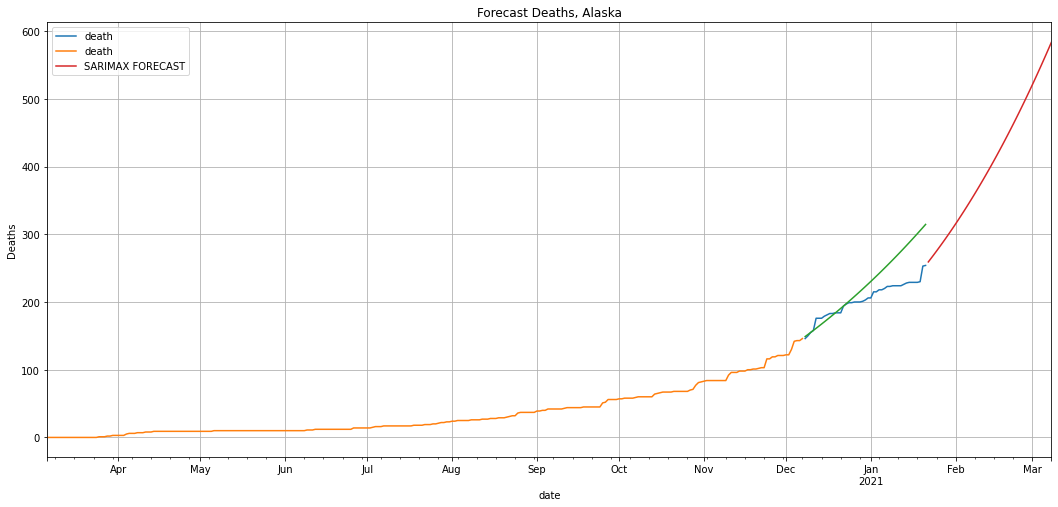

In [70]:
fig, ax = plt.subplots()

test_data['death'].plot(figsize=(16,8),legend=True,title='Forecast Deaths, Alaska',grid=True);
train_data['death'].plot(figsize=(16,8),legend=True,ylabel='Deaths',grid=True);
plt.plot(pd.DataFrame(predictions_AK)); # 'FORECAST' FROM END OF TRAINING DATA
fcast.plot(legend=True,figsize=(18,8)); # SARIMA FORECAST
ax.grid();
plt.show();

### Dashboard Dev, Work in Progress

In [71]:
## getting S&P500 symbols
import requests
url= 'https://api.covidtracking.com/v1/states/daily.csv'
response = requests.get(url)
response.status_code

200

In [72]:
response.

SyntaxError: invalid syntax (<ipython-input-72-d3a67accd037>, line 1)

In [ ]:
def summary_states(df_states,state_postal_code,days):
    
    '''
    *purpose: creates a SARIMA model based on datetime dataframe with column 'death'
              and a state postal code under column 'state'
    
    *inputs:
    df_states: a dataframe of the state Covid data
    state_postal_code: state postal code to get state related death data
    days: number of days out you wish to forecast
    '''
    # create dataframe based on state_postal_code
    df_state = df_states[df_states['state']==state_postal_code]    

    # sort index, lowest index to oldest date, drop na's in death column
    df_state = df_state.sort_index()
    df_state = df_state.dropna(subset=['death'])
    df_state_new = pd.DataFrame(df_state)

    # create stepwise fit model, see summary
    stepwise_fit = auto_arima(df_state_new['death'],start_p=0,start_q=0,max_p=10,
                              max_q=10, seasonal=True, maxiter=1000, method='bfgs',
                              n_jobs=-1,stepwise=True) 

    # auto_arima automatically differences and returns that differencing for the model in the arima_order = stepwise_fit.order below
    ## find correct ARIMA order

    arima_order = stepwise_fit.order

    length = len(df_state_new)-days

    df_actuals = df_state_new
    train_data = df_state_new.iloc[:length]
    test_data = df_state_new.iloc[length:]

    model = sm.tsa.statespace.SARIMAX(train_data['death'],trend='ct', order=arima_order)
    res = model.fit(disp=False)

    start = len(train_data)
    end = len(train_data) + len(test_data) - 1

    predictions_state = res.predict(start,end,typ='endogenous').rename(f'SARIMA{arima_order} Predictions')

    # ensure predictions are in DataFrame format, label index as date to match df_alaska
    # predictions_state = pd.DataFrame(predictions_state)
    predictions_state.index.name = 'date'

    train_data.index.freq = 'D'
    test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
    # perform sort_index on dataframe to correct. set frequencies to match for plotting
    # on same visualization

    # graph test vs. prediction data - {PLOT}
    legend_elements = [Line2D([0], [0], color='b', lw=4, label='Actual Deaths'),
                       Line2D([0], [0], color='r', lw=4, label=f'SARIMA{arima_order} Predictions')]

    fig, ax = plt.subplots(figsize=(20,10));
    ax.plot(test_data['death'])
    ax.plot(predictions_state);
    ax.grid(b=True,alpha=.5)
    plt.title(f'Test Data vs SARIMA, {state_postal_code}')
    ax.legend(handles=legend_elements)
    plt.xlabel('Date')
    plt.ylabel('Deaths')
    plt.show();

    # train model for forecast
    model = sm.tsa.statespace.SARIMAX(df_state['death'],trend='ct', order=arima_order)
    res = model.fit(disp=False)

    # create forecast
    fcast = res.predict(start=len(df_state_new),end=len(df_state_new)+days, typ='endogenous').rename(f'SARIMA{arima_order} {days} Days Forecast')

    # graph forecast deaths, breakout of train and test split is present in graph - {PLOT}
    legend_elements = [Line2D([0], [0], color='b', lw=5, label='Actual Deaths'),
                       Line2D([0], [0], color='r', lw=5, label='Actual Deaths'),
                       Line2D([0], [0], color='y', lw=5, label=f'SARIMA{arima_order} Predictions'),
                       Line2D([0], [0], color='g', lw=5, label=f'SARIMA{arima_order} {days} Day Forecast')]

    fig, ax = plt.subplots(figsize=(20,10));
    ax.plot(train_data['death'])
    ax.plot(test_data['death'])
    ax.plot(predictions_state)
    ax.plot(fcast)
    ax.grid(b=True,alpha=.5)
    plt.title(f'SARIMA {days} Day Forecast, {state_postal_code}')
    ax.legend(handles=legend_elements)
    plt.xlabel('Date')
    plt.ylabel('Deaths')
    plt.show();
    
    return df_actuals
    return fcast # returning fcast to put into plot_forecast

In [ ]:
summary_states(df_states,'CA',30)

In [ ]:
def plot_forecast(df,states=[]):
    if len(states)==0:
        states=None
    pfig = px.line(df)
    return pfig

In [ ]:
def make_options(menu_choices,ignore_cols=['Date']):
    """Returns list of dictionary with {'label':menu_choice,'value':menu_choice}"""
    options = []
    for choice in menu_choices:
        if choice not in ignore_cols:
            options.append({'State':choice,'Postal Code':choice})
    return options

state_options = make_options(state_postal)
make_options(state_postal)

In [ ]:
pio.templates.default = "plotly_dark"

In [ ]:
df_state = df_states[df_states['state']=='CA']    

# sort index, lowest index to oldest date, drop na's in death column
df_state = df_state.sort_index()
df_state = df_state.dropna(subset=['death'])
df_actuals = pd.DataFrame(df_state)
    
## App here
app = JupyterDash('App2')

app.layout = html.Div(children=[
    html.H1('Forecasting'),
    html.H2('COVID-19 Deaths Forecast'),
    dcc.Dropdown(id='states',options=state_options,multi=True),
    dcc.Graph(id=f'{state}',figure=plot_forecast(df_actuals['death'],fcast))])
app    

@app.callback(Output('states','figure'),
              [Input(f'{state}','value')])

def update_forecast(states,state):
    return plot_forecast(df_states[f'{state}'])
app

In [ ]:
today = dt.date.today().strftime("%Y-%m-%d")

def get_data(start_date=df_states,end_date=today,state_codes=state_postal_code):
    
    data = {}
    for state in state_codes:
        try:
            data[state] = pdr.DataReader(df_states,'yahoo',start_date,end_date)['death']
        except:
            print('Error with stock: '+stock)
    df = pd.DataFrame(data).reset_index()
    return df


def plot_forecast_df(df=None,stocks=['FB','AAPL']):
    if df is None:
        df = get_data(stocks)#.reset_index()
    stocks_exist = [s for s in stocks if s in df.columns]
    pfig = px.scatter(df,x='Date',y=stocks_exist)
    return pfig

from jupyter_plotly_dash import JupyterDash
app = JupyterDash('Example', 
                  serve_locally=False)
defaults = ['MSFT','AMZN']
# df = get_data(date(2012, 1, 1))

app.layout = html.Div(children = [
    html.H1('Our AMAZING Dashboard'),
    
    html.Div(children=[
        html.Div(style={"border":'1px solid black','padding':'3px'},id='menu',children=[
            html.H3('Enter state postal codes, separated by a comma.\nPress Enter to update.'),

            dcc.Input(id='choose_stocks',value='MSFT,AMZN',
                      placeholder='MSFT,AAPL',#,
                         style={'width': '90%', 'height': 50}),           

            dcc.DatePickerRange( id='my-date-picker-range',
                                start_date=date(2012,1,1),
                                min_date_allowed=date(2010, 1, 1),
                                max_date_allowed=today,#date.today(),#date(2021),
                                end_date=today,style={'width':'50%'}),#date.today()), #date(2017, 8, 25)),
            html.Button('Submit',id='submit',style={'size':'40 px'})
    
        ]),
        
        dcc.Graph(id='line_plot')

    ])
])

@app.callback(Output('line_plot','figure'),
              [Input('submit','n_clicks')],
              [State('choose_stocks','value'),
               State('my-date-picker-range', 'start_date'),
               State('my-date-picker-range', 'end_date')])
def update_stocks(n_clicks, stocks,start_date,end_date):
    stocks = stocks.split(',')
    plot_df = get_data(start_date,end_date,symbols=stocks)
    return plot_stocks_df(df=plot_df,stocks=stocks)#,start_date,end_date)
    
app

In [ ]:
data = {}
days = 20

for state in state_postal:
    cas_state(df_states,state,days)

In [ ]:
cas_state(df_states,'AK',30)

### Forecast by State, SARIMA (clean up model, sometimes it will go back down, but people can't undie. additionally, work in an exogenous variable with an if statement

#### Here, provide DataFrame, postal code, and number of days in the future you wish to forecast. Code for this function is in Python file, Cust_Func.py

### Alaska

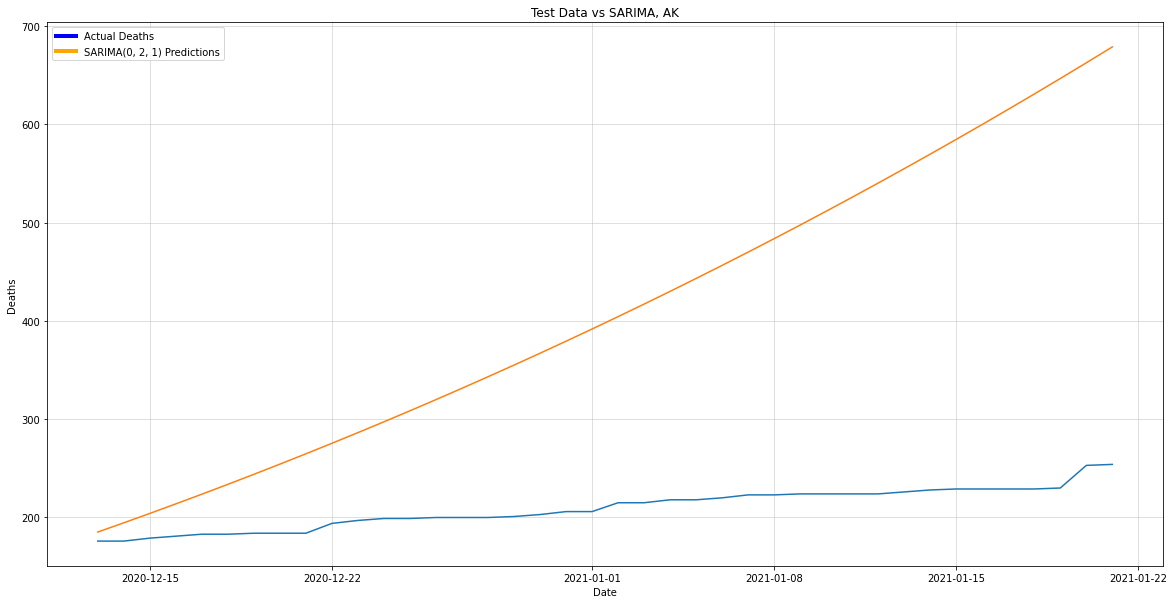

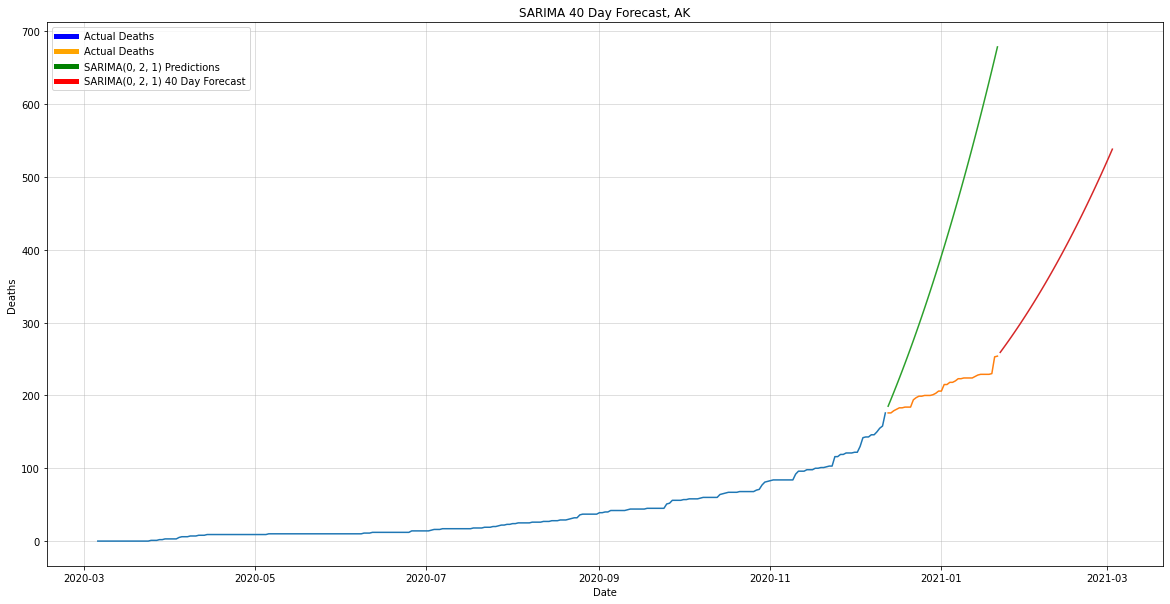

2021-02-27    503.525944
2021-02-28    512.042283
2021-03-01    520.658505
2021-03-02    529.375118
2021-03-03    538.192629
Freq: D, Name: SARIMA(0, 2, 1) 40 Days Forecast, dtype: float64

In [74]:
cas_state(df_states=df_states, state_postal_code='AK',days=40)

### Texas

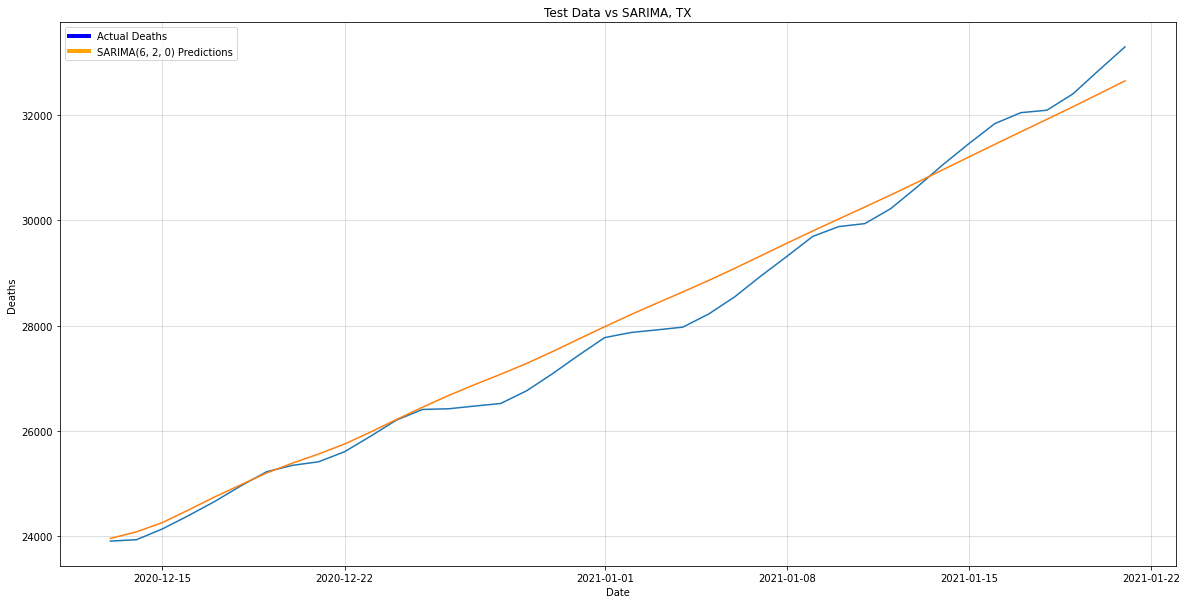

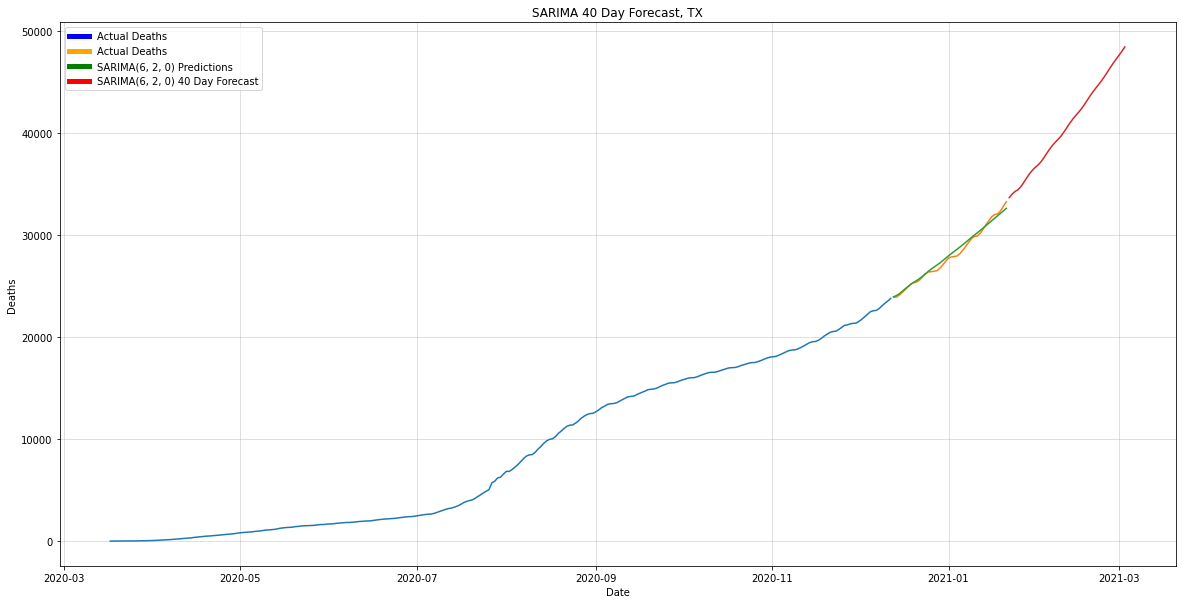

2021-02-27    46880.460371
2021-02-28    47273.745862
2021-03-01    47655.509551
2021-03-02    48049.402788
2021-03-03    48470.785020
Freq: D, Name: SARIMA(6, 2, 0) 40 Days Forecast, dtype: float64

In [75]:
cas_state(df_states=df_states,state_postal_code='TX',days=40) # custom built function in Cust_Func.py

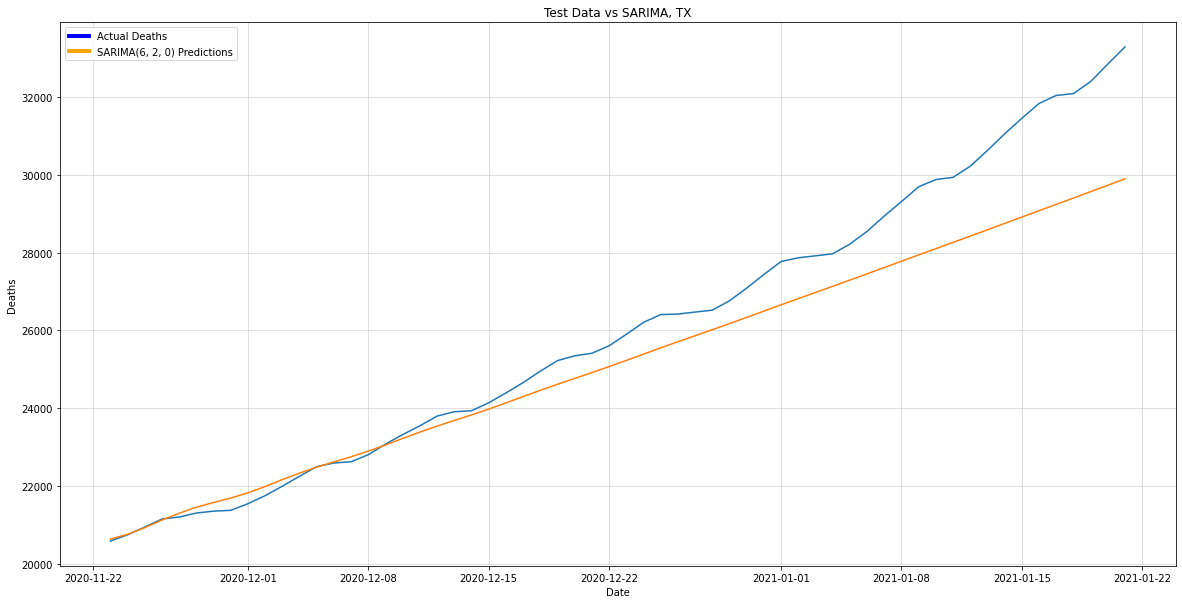

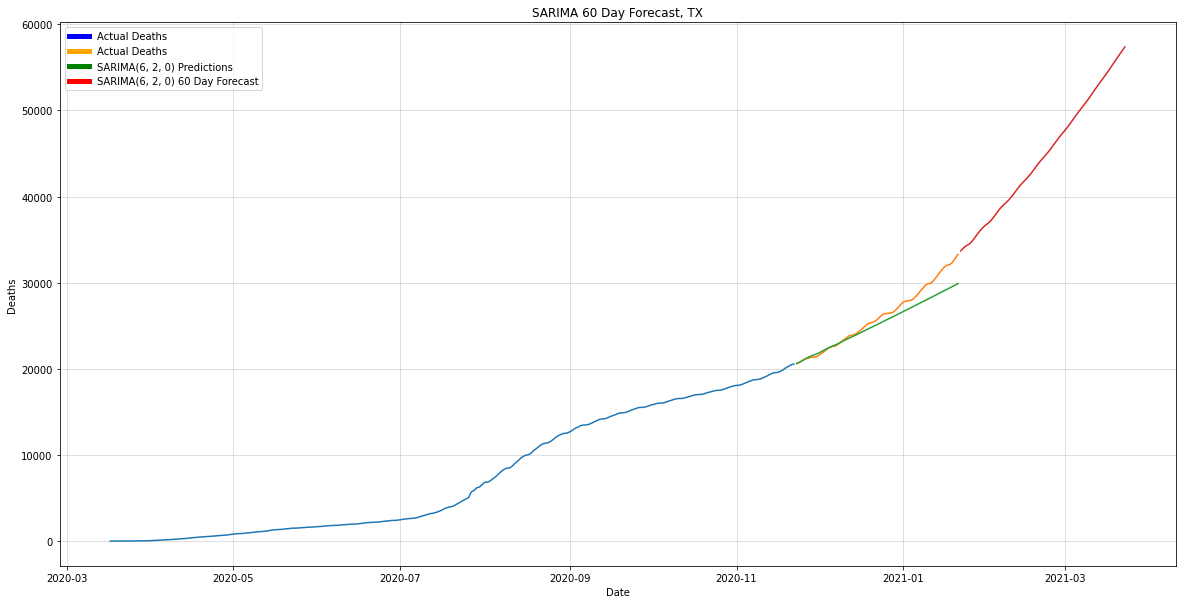

2021-03-19    55539.066735
2021-03-20    56007.164641
2021-03-21    56464.834252
2021-03-22    56916.786800
2021-03-23    57373.210965
Freq: D, Name: SARIMA(6, 2, 0) 60 Days Forecast, dtype: float64

In [76]:
cas_state(df_states=df_states,state_postal_code='TX',days=60)

### Florida

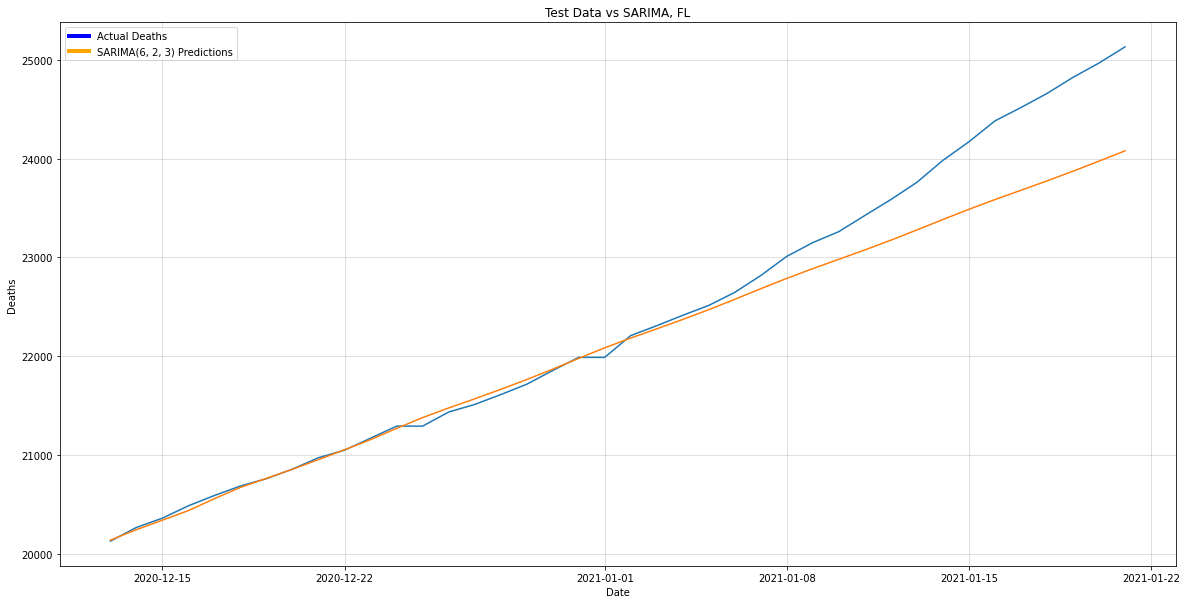

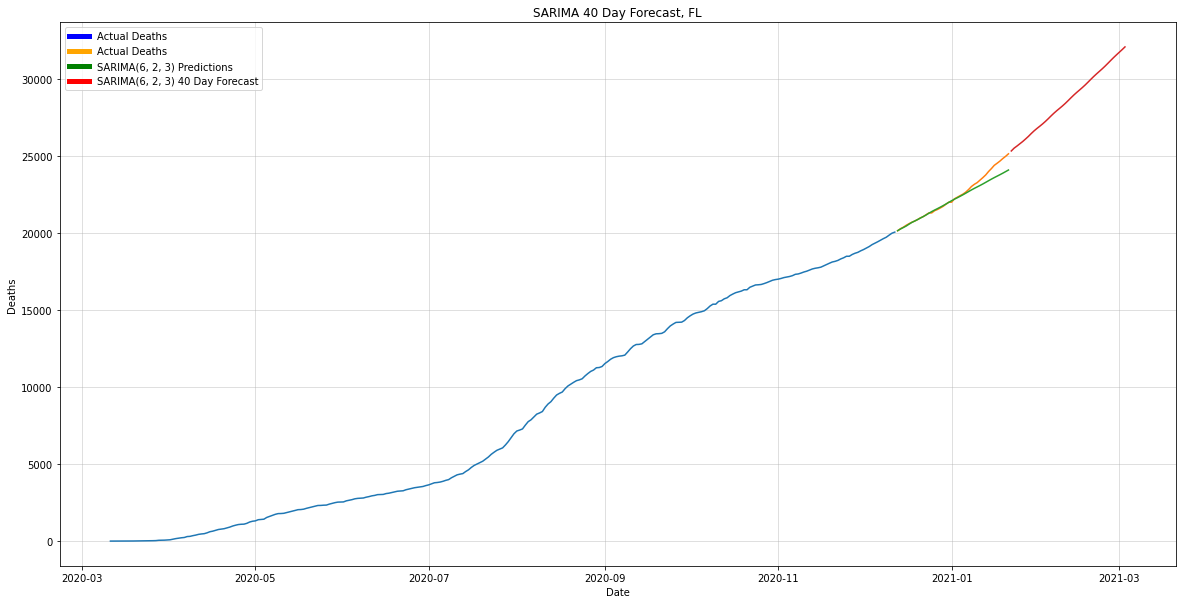

2021-02-27    31373.474057
2021-02-28    31548.436964
2021-03-01    31717.178250
2021-03-02    31887.032140
2021-03-03    32064.669030
Freq: D, Name: SARIMA(6, 2, 3) 40 Days Forecast, dtype: float64

In [77]:
cas_state(df_states,'FL',40)

### New York State

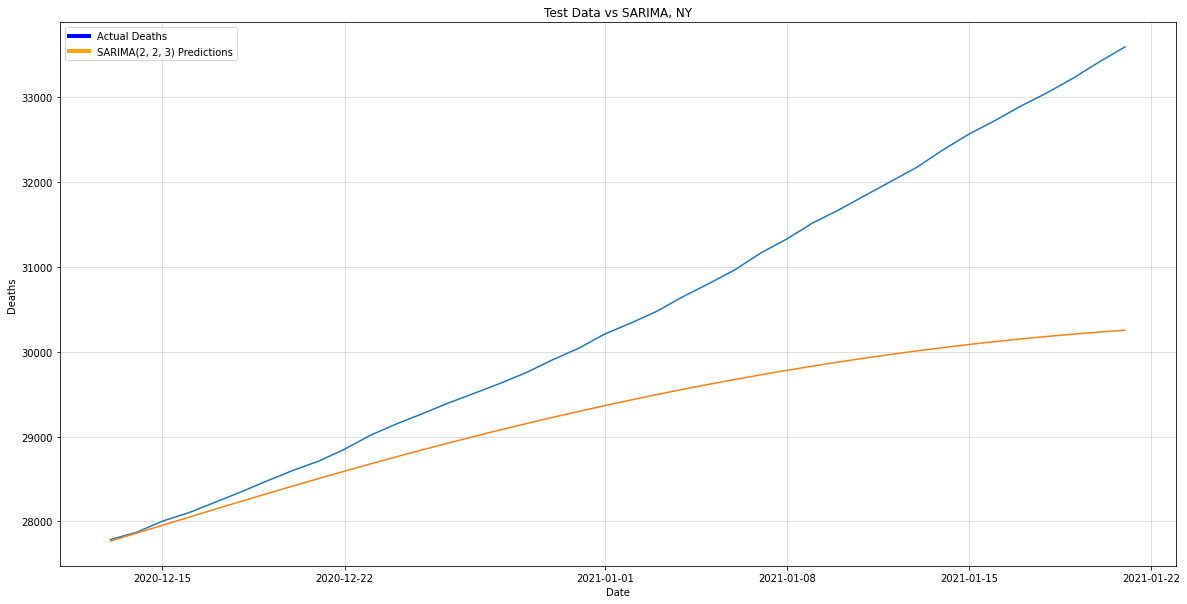

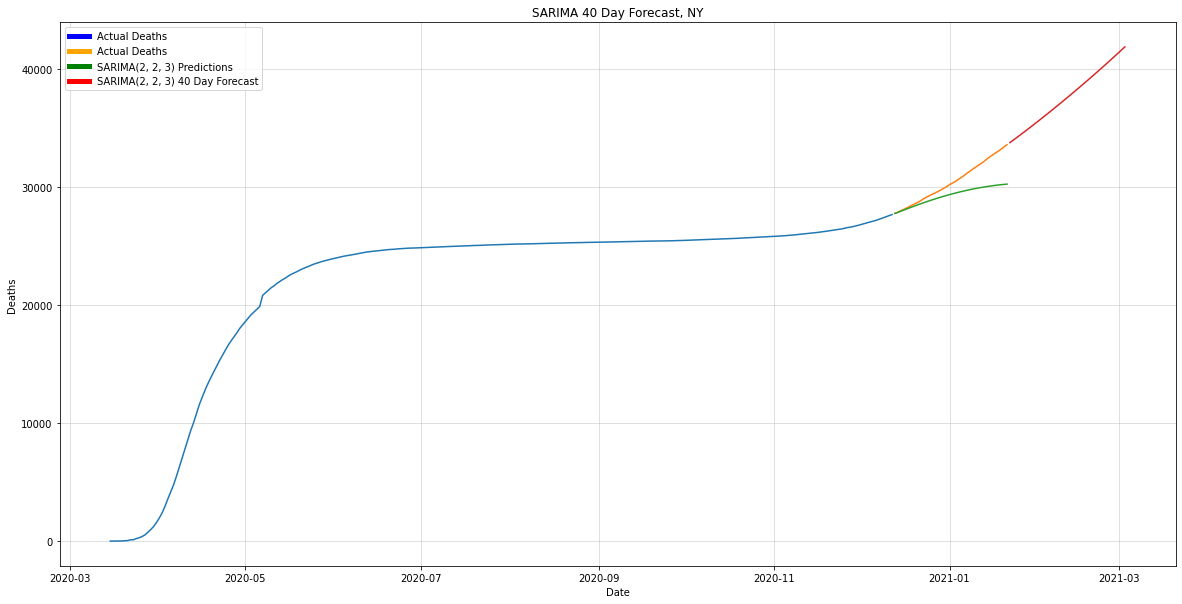

2021-02-27    40986.070029
2021-02-28    41208.168029
2021-03-01    41431.486889
2021-03-02    41656.032841
2021-03-03    41881.812140
Freq: D, Name: SARIMA(2, 2, 3) 40 Days Forecast, dtype: float64

In [78]:
cas_state(df_states,'NY',40)

### California

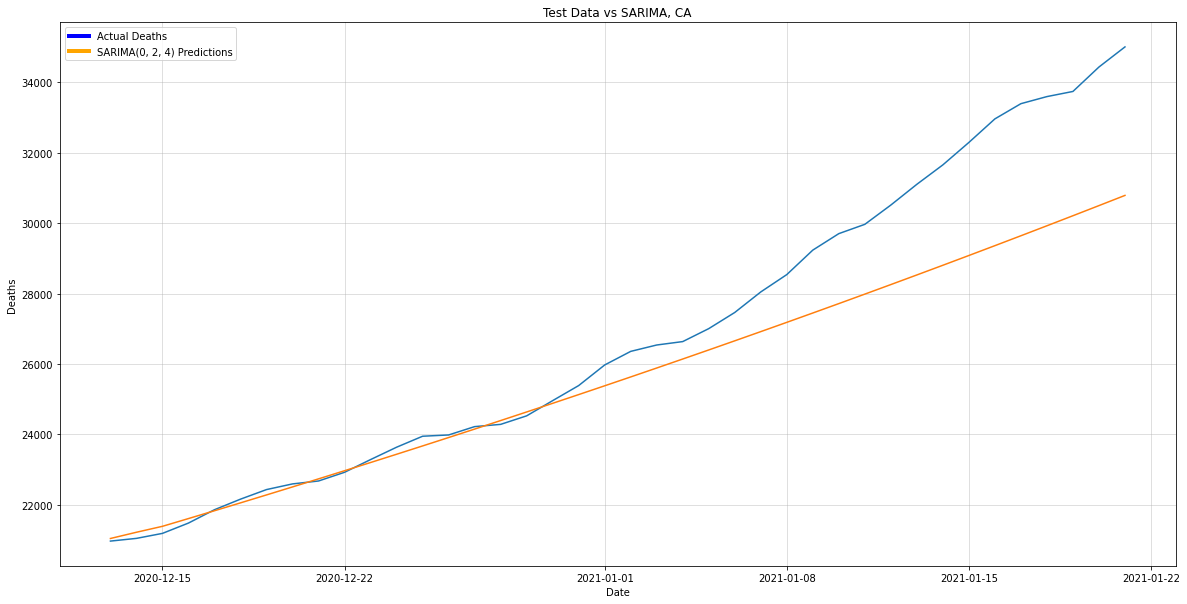

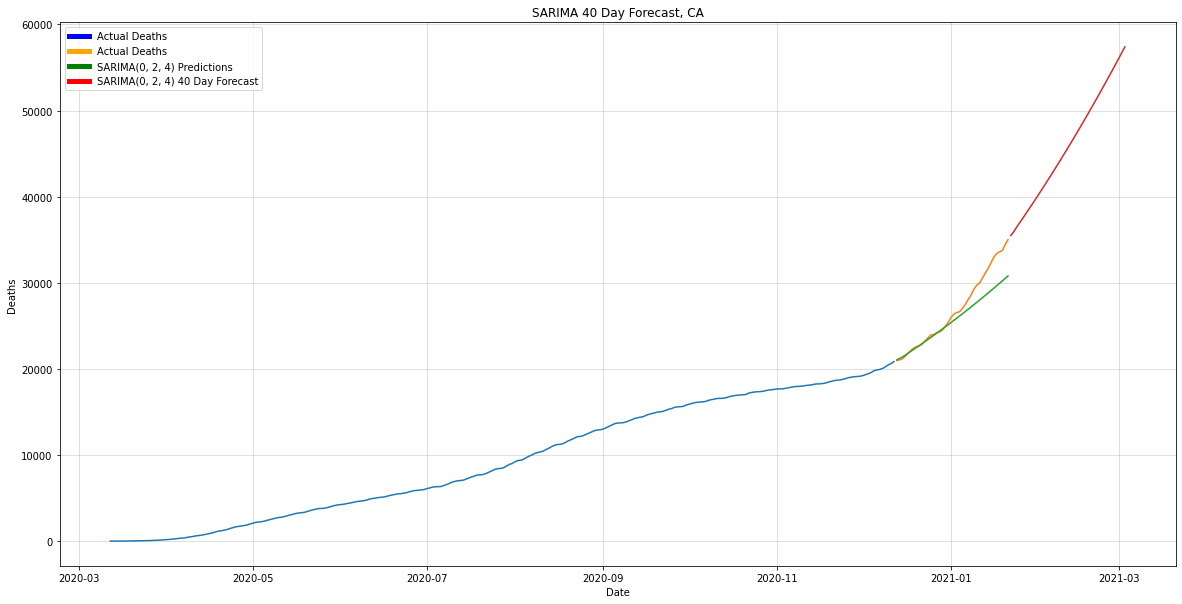

2021-02-27    54908.616093
2021-02-28    55521.294233
2021-03-01    56138.088787
2021-03-02    56759.012231
2021-03-03    57384.077044
Freq: D, Name: SARIMA(0, 2, 4) 40 Days Forecast, dtype: float64

In [79]:
cas_state(df_states,'CA',40)

### Alabama

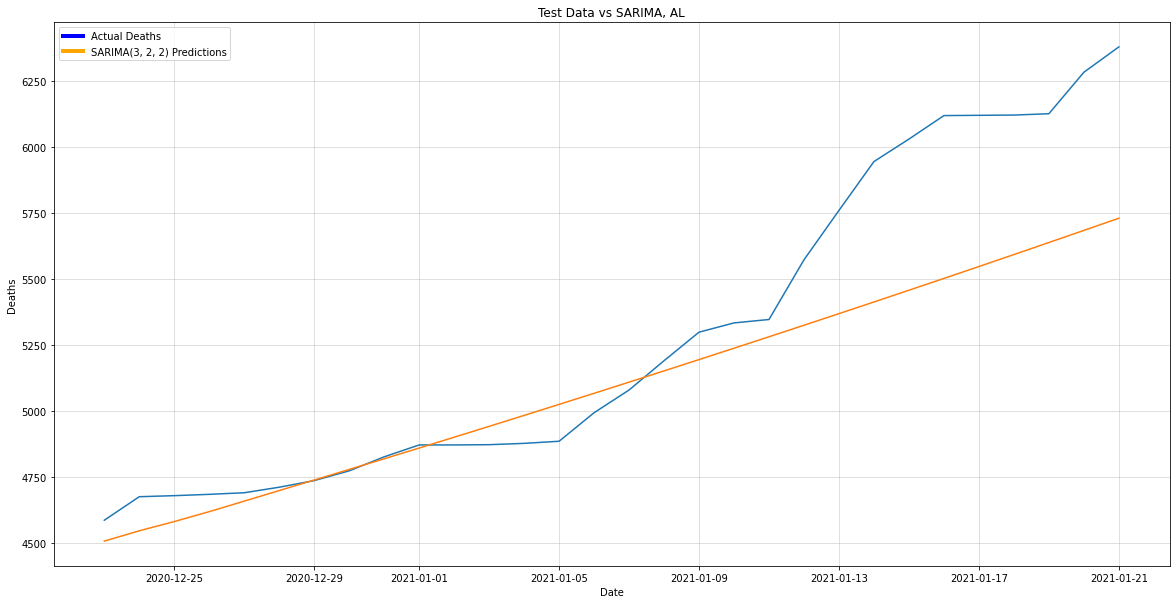

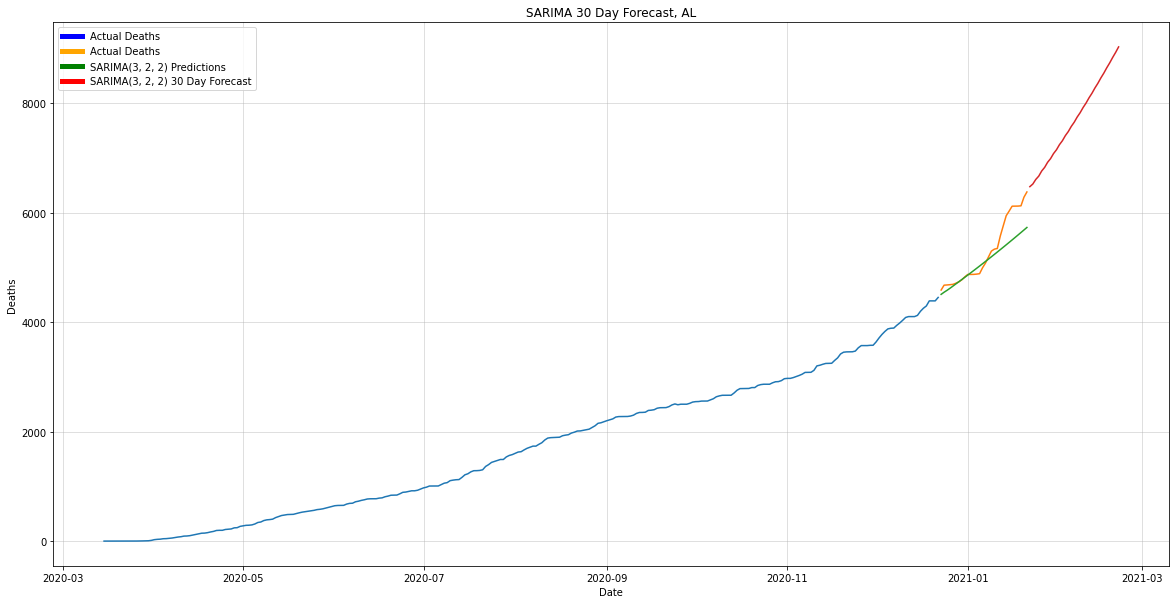

2021-02-17    8648.199543
2021-02-18    8738.025964
2021-02-19    8837.279178
2021-02-20    8929.051111
2021-02-21    9029.410695
Freq: D, Name: SARIMA(3, 2, 2) 30 Days Forecast, dtype: float64

In [80]:
cas_state(df_states,'AL',30)

### Colorado

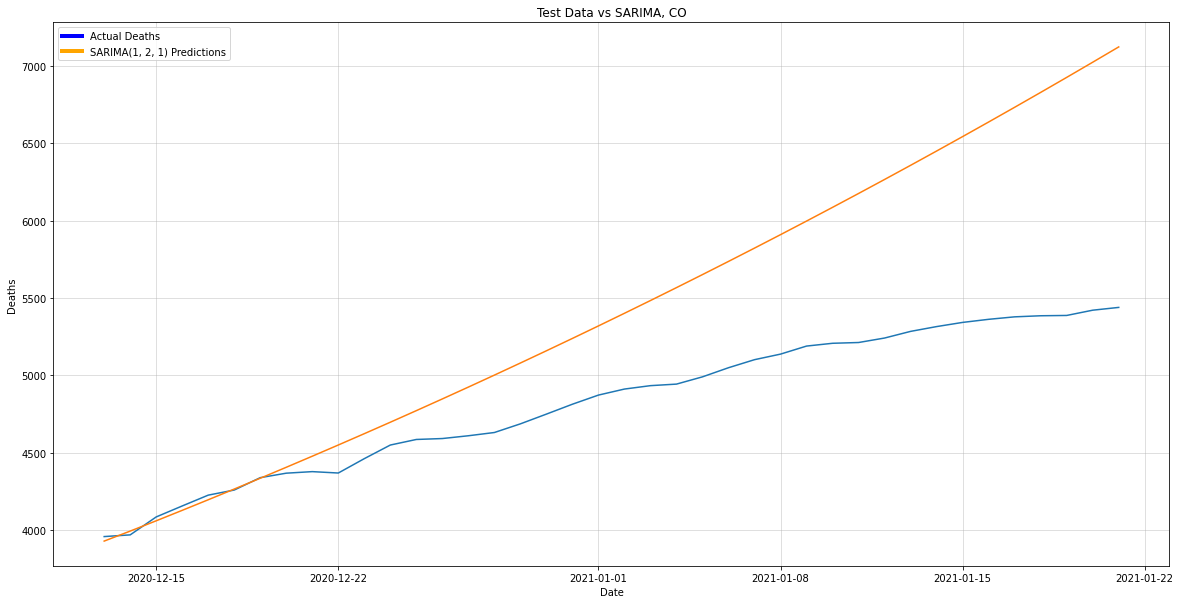

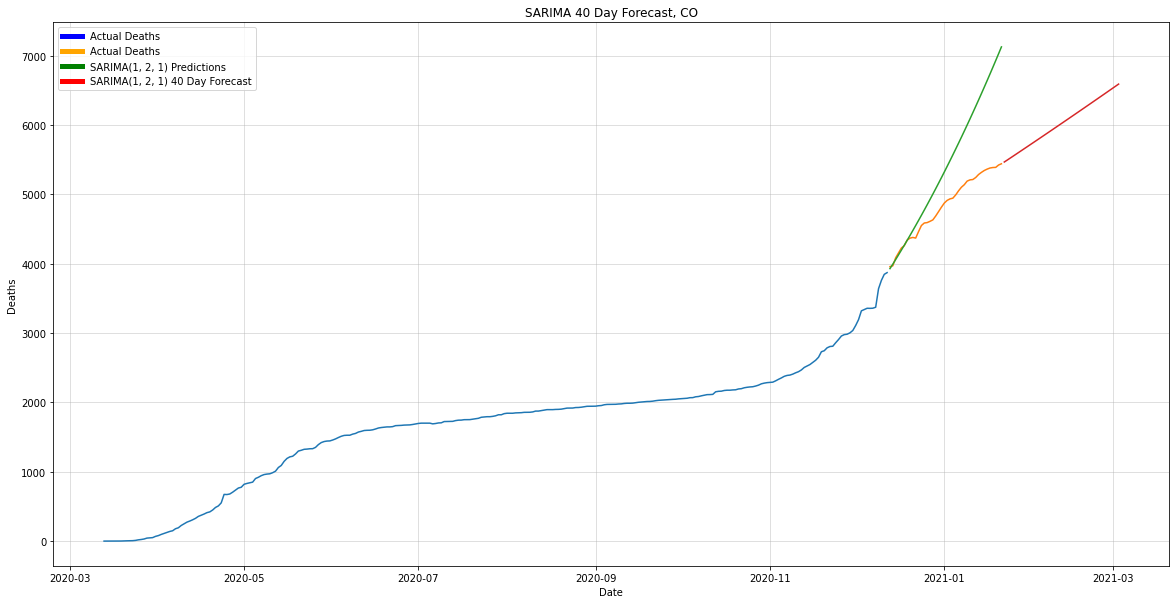

2021-02-27    6474.053125
2021-02-28    6502.666334
2021-03-01    6531.307968
2021-03-02    6559.977784
2021-03-03    6588.675538
Freq: D, Name: SARIMA(1, 2, 1) 40 Days Forecast, dtype: float64

In [81]:
cas_state(df_states,'CO',40)

### All States

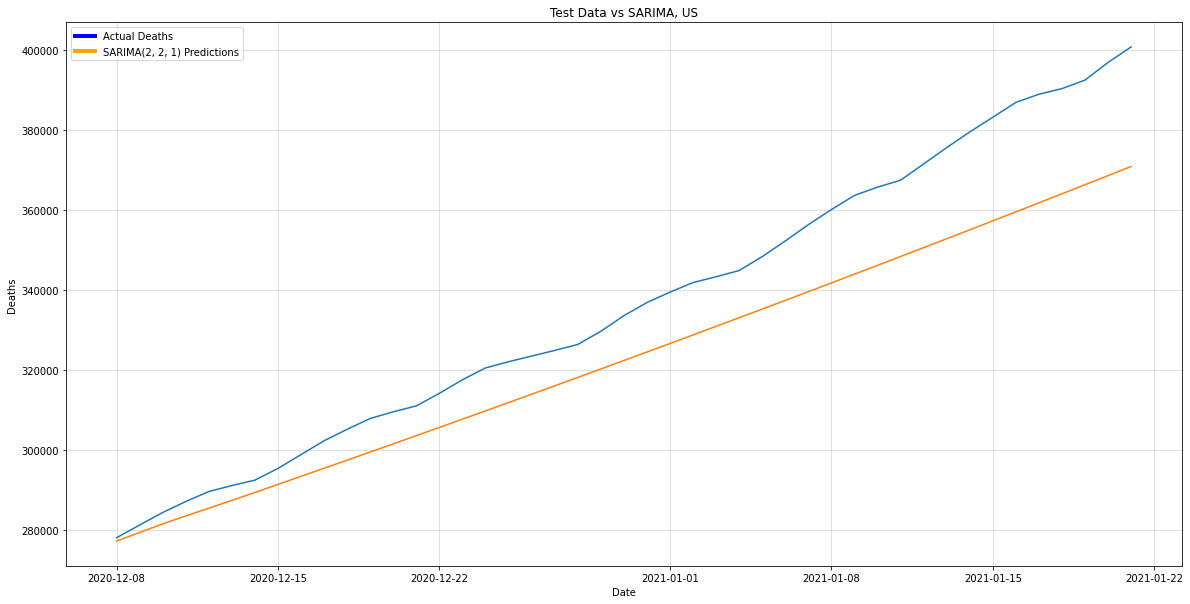

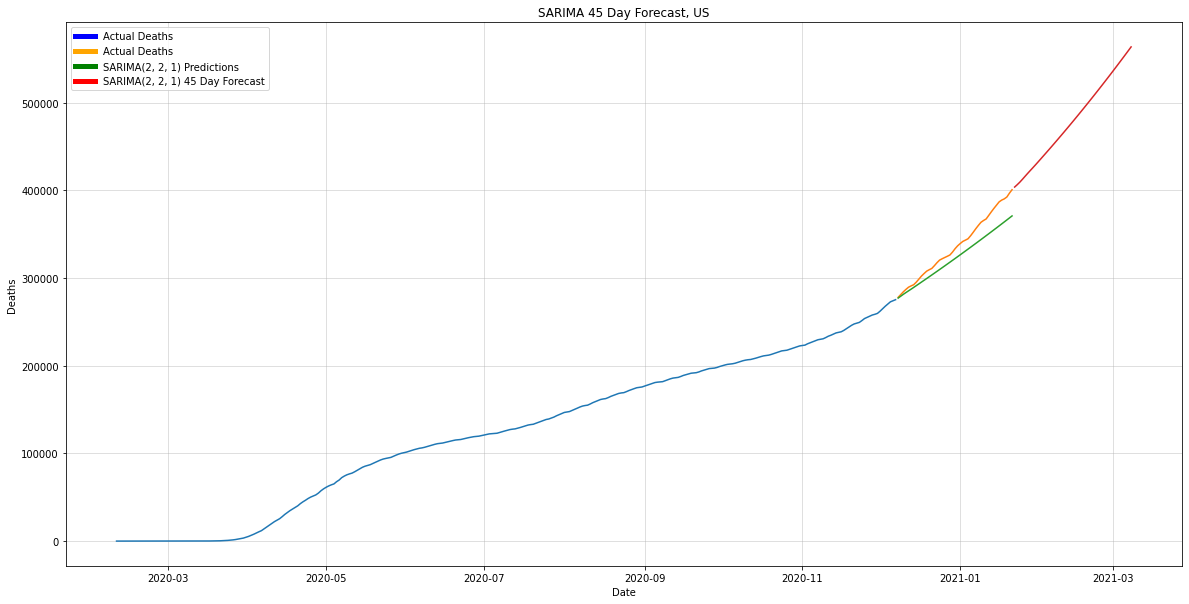

2021-03-04    547728.796460
2021-03-05    551663.965436
2021-03-06    555619.510135
2021-03-07    559595.487736
2021-03-08    563591.955232
Freq: D, Name: SARIMAX(2, 2, 1) Predictions, dtype: float64

In [82]:
cas_usa(df_whole_US,45)

### U.S. Analysis

The graph of cumulative deaths in the United States was fairly steady and linear beginning in March of 2020. The death rate suddenly accelerated in December of 2020 and has continued on that accelerated trend since then. My model projects 540,000 deaths by March, 2021.

Without drastic measures, changes in behavior, and widespread dissemination of the vaccine, this trend will continue and hundreds of thousands more Americans will lose their lives to COVID-19. 

## Univariate Forecast with RNN

### Texas

Epoch 1/4
231/231 [==============================] - 9s 35ms/step - loss: 0.0197
Epoch 2/4
231/231 [==============================] - 8s 35ms/step - loss: 0.0020
Epoch 3/4
231/231 [==============================] - 8s 35ms/step - loss: 7.2926e-04
Epoch 4/4
231/231 [==============================] - 8s 34ms/step - loss: 1.8687e-04


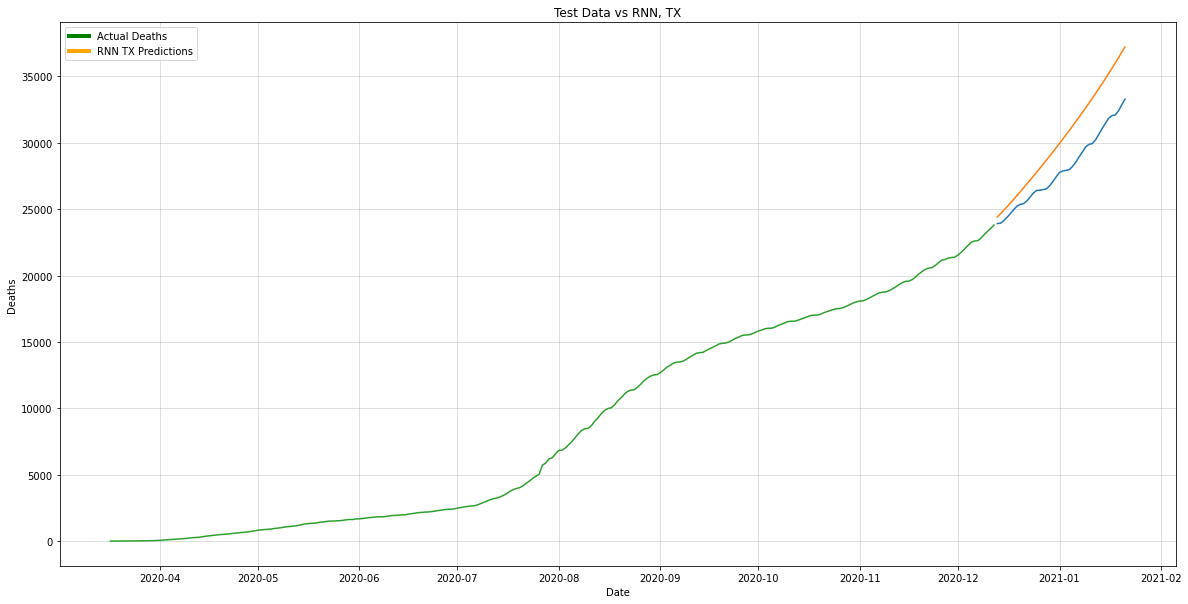

In [83]:
create_nn(df_states=df_states,state_postal_code='TX',days=40,epochs=4) # eg 

### Florida

Epoch 1/4
237/237 [==============================] - 9s 34ms/step - loss: 0.0251
Epoch 2/4
237/237 [==============================] - 8s 35ms/step - loss: 1.4651e-04
Epoch 3/4
237/237 [==============================] - 8s 35ms/step - loss: 2.7795e-04
Epoch 4/4
237/237 [==============================] - 8s 35ms/step - loss: 1.3414e-04


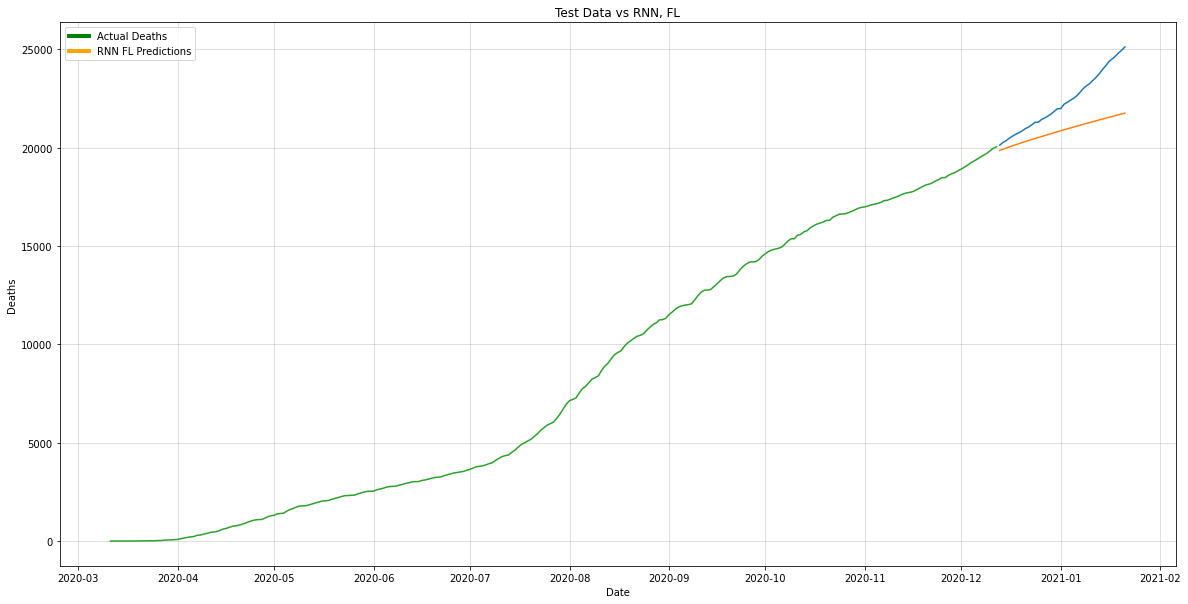

In [84]:
create_nn(df_states,'FL',40,epochs=4)

### California

Epoch 1/4
236/236 [==============================] - 9s 34ms/step - loss: 0.0573
Epoch 2/4
236/236 [==============================] - 8s 35ms/step - loss: 2.5645e-04
Epoch 3/4
236/236 [==============================] - 8s 35ms/step - loss: 1.5958e-04
Epoch 4/4
236/236 [==============================] - 8s 36ms/step - loss: 1.5161e-04


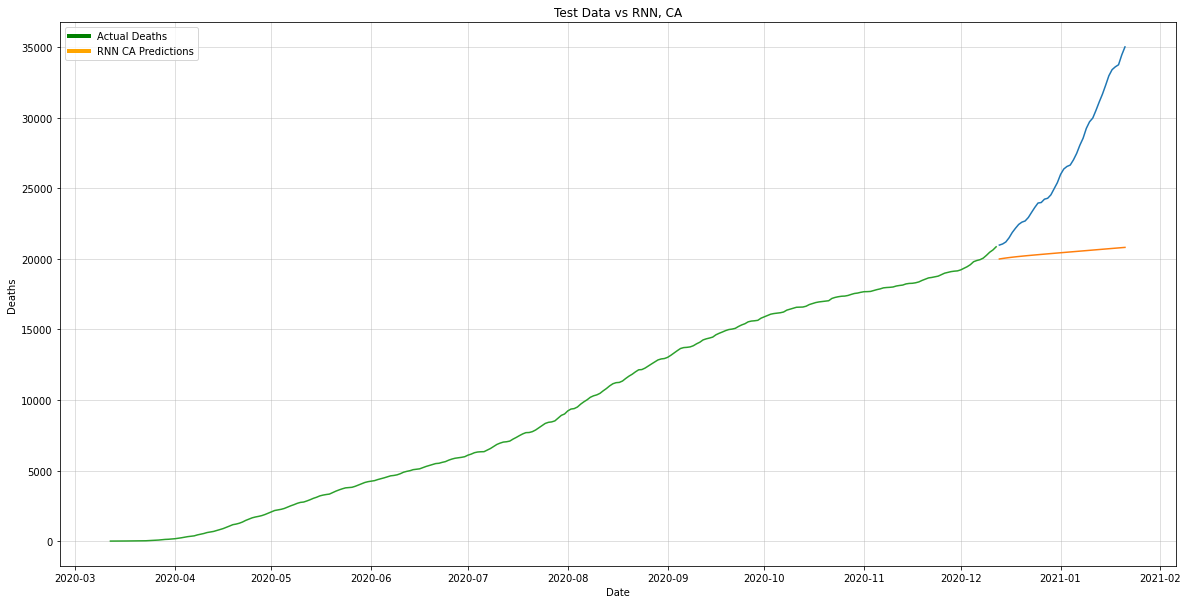

In [85]:
create_nn(df_states,'CA',40,epochs=4)

### Using an Exogenous Variable with SARIMAX

In [86]:
clean_df(df_states,.02)

,state,positive,negative,totalTestResultsSource,totalTestResults,lastUpdateEt,dateModified,checkTimeEt,death,dateChecked,...,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
date,,,,,,,,,,,,,,,,,,,,,
2021-01-21,AK,50941.0,1380026.0,totalTestsViral,1430967.0,1/21/2021 03:59,2021-01-21T03:59:00Z,01/20 22:59,254.0,2021-01-21T03:59:00Z,...,10845,1430967,1,7,86aafafe0b00c7f3e6560a03504d84b8c78c6160,0,0,0,0,0
2021-01-21,AL,432536.0,1715242.0,totalTestsPeopleViral,2058224.0,1/21/2021 11:00,2021-01-21T11:00:00Z,01/21 06:00,6379.0,2021-01-21T11:00:00Z,...,7587,2147778,96,349,5f92e66211408aa406eeac8c5a2a8df6ea781dff,0,0,0,0,0
2021-01-21,AR,279220.0,2091292.0,totalTestsViral,2315535.0,1/21/2021 00:00,2021-01-21T00:00:00Z,01/20 19:00,4496.0,2021-01-21T00:00:00Z,...,13041,2370512,55,73,006e2c2bc783934f97cd193ff6d289ce2839dbab,0,0,0,0,0
2021-01-21,AS,0.0,2140.0,totalTestsViral,2140.0,12/1/2020 00:00,2020-12-01T00:00:00Z,11/30 19:00,0.0,2020-12-01T00:00:00Z,...,0,2140,0,0,29189567fcff71a3b768e7574f0c4251e04e11fd,0,0,0,0,0
2021-01-21,AZ,699942.0,2628346.0,totalTestsViral,6215572.0,1/21/2021 00:00,2021-01-21T00:00:00Z,01/20 19:00,11772.0,2021-01-21T00:00:00Z,...,69803,3328288,244,397,4d8f854194b7981e0aa7d7b16602845a89b33196,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-14,NJ,NaN,NaN,posNeg,0.0,NaN,NaN,NaN,0.0,NaN,...,0,0,0,0,6d74e2c9d73e5222e1819cf58d39a59dd19bffee,0,0,0,0,0
2020-02-13,NJ,NaN,NaN,posNeg,0.0,NaN,NaN,NaN,0.0,NaN,...,0,0,0,0,b0269e519c685d2937b037df7dbe4a12b325a603,0,0,0,0,0
2020-02-12,NJ,NaN,NaN,posNeg,0.0,NaN,NaN,NaN,0.0,NaN,...,0,0,0,0,dc77f570d79d1398d81a9b86c99f901f37c5e0fe,0,0,0,0,0


In [89]:
dataframe_out.info()

NameError: name 'dataframe_out' is not defined

## Questions

## Conclusions

## Further Work